#  1. Bussiness Problem

## 1.1 Description 

 
 <br>
 **Problem Statement** : Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

## 1.2 Introduction 

Personalized Medicine refers to the idea of analyzing an individual patient's tumor to determine what combination of drugs will work best for that paricular individual. For doing this, the thousands of genetic mutation in cancer tumor needs to be distinguished into a. the mutations that contribute to tumor growth (drivers) b.the mutation which are neutral and do not contribute to tumor growth (passengers). The interpretation of genetic mutations is being done is currently done manually.<br>

In this project we are going to automate the classification of these drivers from the passengers.<br>

# 2. Machine Learning Problem Foundation

## 2.1 Data 

### 2.1.1 Data Overview 

**Source:** https://www.kaggle.com/c/msk-redefining-cancer-treatment/data<br>
 - We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that human experts/pathologists use to classify the genetic mutations.
 - Both these data files are have a common column called ID

 - Data file's information:

        training_variants (ID , Gene, Variations, Class)
        training_text (ID, Text)

### 2.1.2. Example Data Point

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

## 2.2. Mapping the real-world problem to an ML problem 

### 2.2.1. Type of Machine Learning Problem

There are nine different classes a genetic mutation can be classified into => Multi class classification problem

### 2.2.2. Performance Metric

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s):

 - Multi class log-loss
 - Confusion matrix

### 2.2.3 Machine Learing Objectives and Constraints

**Objective:** Predict the probability of each data-point belonging to each of the nine classes.

**Constraints:**

 - Interpretability
 - Class probabilities are needed.
 - Penalize the errors in class probabilites => Metric is Log-loss.
 - No Latency constraints.

# 3.Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

/Users/akash/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 3.1Reading Data

### 3.1.1Reading Gene and Variation Data


In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
Fields are<br>

 - **ID** : the id of the row used to link the mutation to the clinical evidence <br>
 - **Gene** : the gene where this genetic mutation is located<br>
 - **Variation** : the aminoacid change for this mutations<br>
 - **Class** : 1-9 the class this genetic mutation has been classified on<br>

### 3.1.2Reading Text Data

In [3]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [95]:
# converting the train text to a list
train_text_list=data_text.TEXT.tolist()
pat1_text=train_text_list[1]
print (type(pat1_text))

<class 'str'>


In [96]:
len(str(train_text_list[:1]).split(" "))

4371

** 3.1.2.1 Unique Variations**

In [98]:
unique_variation= set(data.Variation)
print (unique_variation)
#print pd.unique(train_varients.Variation)

{'D24Y', 'P2476L', 'G101W', 'R110L', 'E839K', 'Exon 20 insertions/deletions', 'R268A', 'A532H', 'Q22K', 'Y1248F', 'Y16C', 'D1067V', 'W1038C', 'L46F', 'M232T', 'K1452N', 'T507K', 'G1202R', 'P287S', 'D816H', 'S196N', 'A111P', 'I49S', 'Hypermethylation', 'H214Q', 'D258N', 'E279K', 'W308C', 'M784V', 'R882C', 'MIR143-NOTCH1 Fusion', 'V411L', 'S746fs', 'T488_P492del', 'D770_N771insD', 'V506A', 'F248S', 'Y1045W', 'K666R', 'ESR1-YAP1 Fusion', 'C1483W', 'I1616N', 'I195T', 'Q79K', 'R1200W', 'ETV6-PDGFRB Fusion', 'E518A', 'P81T', 'F133L', 'E31K', 'D816G', 'R158C', 'I408V', 'A648T', 'G464E', 'S56I', 'D641N', 'L330R', 'T17A', 'R337C', 'E996K', 'A2770T', 'CUX1-FGFR1 Fusion', 'A263V', 'L576P', 'R1209W', 'D2033N', 'P278L', 'N234I', 'R182W', 'V559del', 'N826S', 'I89T', 'A121V', 'I1680N', 'L838V', 'Y234H', 'R264C', 'L692F', 'E709A', 'L362R', 'Y35C', 'D537E', 'L493V', 'R370C', 'S310Y', 'P287A', 'L833V', 'D3095E', 'E60L', 'CEP85L-PDGFRB Fusion', 'R1625C', 'N1819Y', 'E1286V', 'T41A', 'G660D', 'D331G', 'R62

**3.1.2.2 Unique Genes **

In [102]:
unique_genes=set(data.Gene)
print (unique_genes)
print (len(unique_genes))

{'CDK12', 'RET', 'FLT1', 'RUNX1', 'BARD1', 'BRIP1', 'KEAP1', 'FBXW7', 'CDKN2A', 'TET2', 'MTOR', 'PTPRT', 'ARID5B', 'BTK', 'XPO1', 'TSC2', 'U2AF1', 'ELF3', 'CDK6', 'RAD50', 'ETV1', 'MDM4', 'CCND1', 'CCND3', 'CHEK2', 'NTRK3', 'SDHC', 'MDM2', 'RXRA', 'SPOP', 'PTEN', 'PIK3R1', 'NTRK2', 'GNA11', 'PRDM1', 'KDM5C', 'ASXL1', 'DNMT3B', 'PMS1', 'ERCC3', 'ABL1', 'NFKBIA', 'TCF7L2', 'TERT', 'EZH2', 'NFE2L2', 'STK11', 'DNMT3A', 'NF2', 'DICER1', 'XRCC2', 'TGFBR2', 'IKZF1', 'MPL', 'SRSF2', 'CTNNB1', 'CTCF', 'ARID2', 'PMS2', 'AGO2', 'RAD51D', 'FAM58A', 'BCL10', 'NOTCH1', 'ASXL2', 'FANCC', 'MAP2K1', 'RARA', 'MAP2K4', 'JAK1', 'GLI1', 'NPM1', 'SOX9', 'NSD1', 'SRC', 'PIK3R2', 'CREBBP', 'B2M', 'RASA1', 'MEN1', 'ERBB2', 'RB1', 'IDH2', 'TP53BP1', 'FOXP1', 'CARD11', 'VHL', 'ACVR1', 'TGFBR1', 'DDR2', 'PTPRD', 'SMARCA4', 'KDM5A', 'KNSTRN', 'WHSC1L1', 'MAP3K1', 'FGFR3', 'NKX2-1', 'IL7R', 'AKT2', 'EP300', 'MYC', 'ESR1', 'HLA-A', 'CCNE1', 'CEBPA', 'PDGFRB', 'BRAF', 'NCOR1', 'KDM6A', 'CBL', 'NRAS', 'HIST1H1C', 'RAD

**3.1.2.3 Merging the two train data set and building into one**

In [103]:
train = pd.merge(data,data_text, on='ID')
train.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [105]:
# reading the numbers!
print("there are ", len(train["Variation"]),"rows for the training set")
print("there are ",len(unique_variation), " different values for variations")
print("there are ",len(unique_genes), " different values for genes")


there are  3321 rows for the training set
there are  2996  different values for variations
there are  264  different values for genes


In [107]:
print("Train variant shape : ",data.shape)
print("Train text shape : ",data_text.shape)

Train variant shape :  (3321, 4)
Train text shape :  (3321, 2)


In [108]:
#Column Names In Our Dataset
print (train.columns)

Index(['ID', 'Gene', 'Variation', 'Class', 'TEXT'], dtype='object')


In [109]:
#checking for null values in the merged data
train.TEXT.isnull().values.any()

False

### 3.2 The Number Of Data Points For Each Class

In [110]:
# counting
train["Class"].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

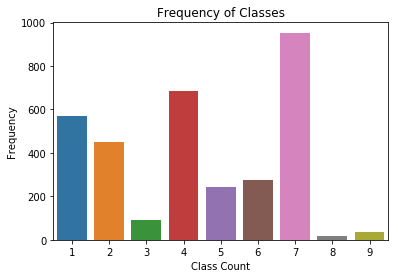

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(x="Class", data=data)
plt.ylabel('Frequency')
plt.xlabel('Class Count')
plt.title("Frequency of Classes")
plt.show()

**Inference** <br>
 - Class levels 3, 8, 9 are notably having least frequency or occurance.
 - Class Levels 5, 6 are of comparable, medium-low frequency
 - Class Levels 1, 2, 4 are of comparable, medium-high frequency
 - Class Level 7 is clearly the most frequent one

### 3.3 Length Of Text Field For Each Class 

In [114]:
# we add a new column in the dataframe called 'LenText' which contains the length of each text field
train.loc[:,'LenText'] =(train['TEXT'].str.len()).astype(int)
print (train.head())

   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  LenText  
0  cyclin dependent kinases cdks regulate variety...    30836  
1  abstract background non small cell lung cancer...    27844  
2  abstract background non small cell lung cancer...    27844  
3  recent evidence demonstrated acquired uniparen...    28093  
4  oncogenic mutations monomeric casitas b lineag...    31649  


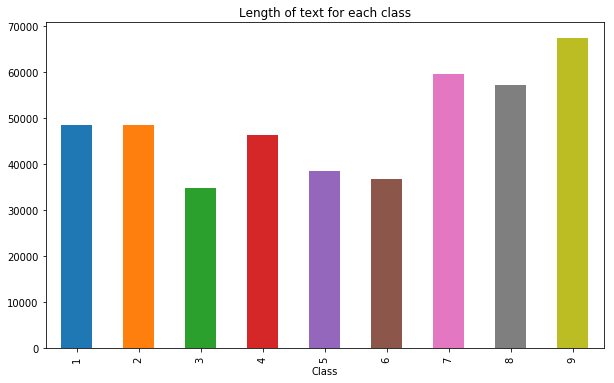

In [115]:
train.groupby('Class')['LenText'].mean().plot(kind='bar',title='Length of text for each class',figsize=(10,6))
plt.show()

** Inference**

 - For Class 9 mutation, the description of the text is highest
 - For Class 7 and 8, the description length is similar
 - For Class 1,2 and 4, the description length is almost similar
 - For Class 3,5 and 6, the description length is least

### 3.4 Word count of each text field

In [116]:
# creating a new column called Text Count
train.loc[:, 'Text_count']  = train["TEXT"].apply(lambda x: len(x.split()))
train.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  LenText  Text_count  
0  cyclin dependent kinases cdks regulate variety...    30836        4370  
1  abstract background non small cell lung cancer...    27844        4139  
2  abstract background non small cell lung cancer...    27844        4139  
3  recent evidence demonstrated acquired uniparen...    28093        3841  
4  oncogenic mutations monomeric casitas b lineag...    31649        4254

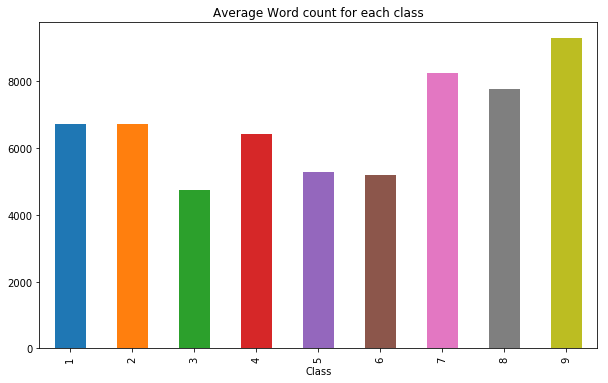

In [117]:
# plot for word count
train.groupby('Class')['Text_count'].mean().plot(kind='bar',title='Average Word count for each class',figsize=(10,6))
plt.show()

It has similar distribution to that of the character count.

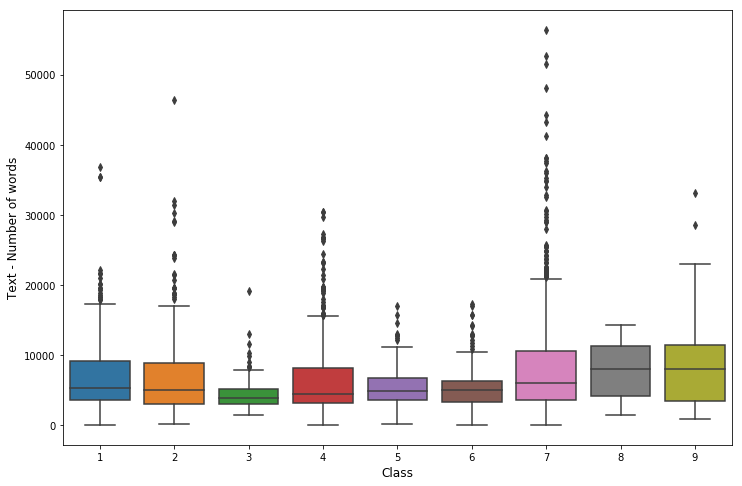

In [118]:
# box plot for class and word count
plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='Text_count', data=train)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

In [119]:
print (max(train['Text_count']))

56425


#### 3.4.1 Finding Null values in the text field 

count_grp = train.groupby('Class')['Text_count']
count_grp.describe()

In [121]:
train[train['Text_count']==1.0]

ID    Gene             Variation  Class  TEXT  LenText  Text_count
1109  1109   FANCA                S1088F      1  nan         4           1
1277  1277  ARID5B  Truncating Mutations      1  nan         4           1
1407  1407   FGFR3                 K508M      6  nan         4           1
1639  1639    FLT1         Amplification      6  nan         4           1
2755  2755    BRAF                 G596C      7  nan         4           1

In [122]:
train[train['Text_count']==1.0].count()

ID            5
Gene          5
Variation     5
Class         5
TEXT          5
LenText       5
Text_count    5
dtype: int64

**Inference** : So we can conclude that there are some fields where there is no values.

### 3.5 Unique Genes Per Class 

In [123]:
gene_class={}
for i in range(1,10):
    gene_class[i]=set()
    for index, row in train.iterrows():
        if(i==(row['Class'])):
                gene_class[i].add(row['Gene'])
print (gene_class)

{1: {'CDK12', 'RET', 'RUNX1', 'BARD1', 'BRIP1', 'KEAP1', 'FBXW7', 'CDKN2A', 'TET2', 'PTPRT', 'ARID5B', 'TSC2', 'ELF3', 'RAD50', 'CHEK2', 'SPOP', 'PTEN', 'PIK3R1', 'NTRK2', 'PRDM1', 'ASXL1', 'ERCC3', 'TCF7L2', 'STK11', 'DNMT3A', 'NF2', 'DICER1', 'XRCC2', 'TGFBR2', 'CTCF', 'ARID2', 'PMS2', 'AGO2', 'RAD51D', 'FAM58A', 'BCL10', 'NOTCH1', 'ASXL2', 'FANCC', 'MAP2K4', 'JAK1', 'GLI1', 'NPM1', 'SOX9', 'PIK3R2', 'CREBBP', 'B2M', 'RASA1', 'ERBB2', 'RB1', 'TP53BP1', 'FOXP1', 'VHL', 'TGFBR1', 'PTPRD', 'SMARCA4', 'KNSTRN', 'MAP3K1', 'FGFR3', 'EP300', 'HLA-A', 'CEBPA', 'PDGFRB', 'NCOR1', 'KDM6A', 'CBL', 'HIST1H1C', 'RAD21', 'PIM1', 'APC', 'RYBP', 'FAT1', 'CDKN2B', 'ETV6', 'ATRX', 'BCL2L11', 'SMARCB1', 'BRCA1', 'RAD51C', 'SMAD3', 'GATA3', 'BCOR', 'STAG2', 'FOXO1', 'ERCC2', 'NF1', 'AR', 'SETD2', 'MLH1', 'IGF1R', 'HNF1A', 'CDKN1A', 'CDKN1B', 'RNF43', 'FUBP1', 'ARID1A', 'TSC1', 'MSH2', 'ARID1B', 'POLE', 'ERCC4', 'KMT2D', 'PIK3R3', 'MED12', 'CTLA4', 'INPP4B', 'CASP8', 'SMAD2', 'TP53', 'PTPN11', 'BAP1', 'E

In [124]:
unique_gene_count={}

for k,v in sorted(gene_class.items()):
    unique_gene_count[k]=len(v)
print (unique_gene_count)

{1: 142, 2: 96, 3: 26, 4: 92, 5: 48, 6: 56, 7: 108, 8: 12, 9: 10}


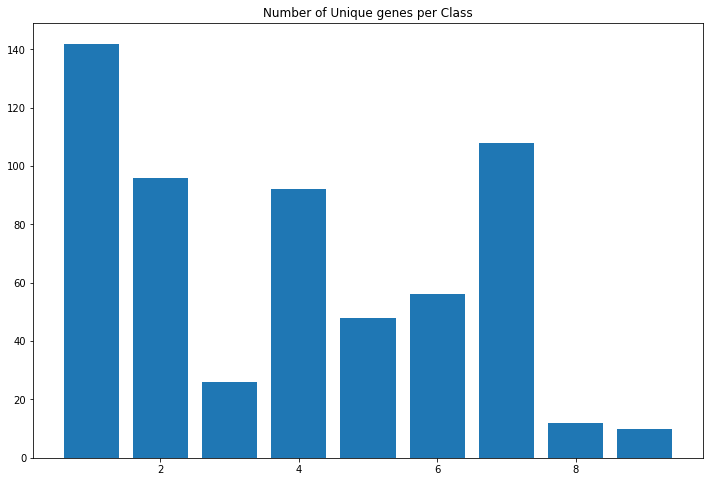

In [126]:
plt.figure(figsize=(12,8))
plt.bar(unique_gene_count.keys(),unique_gene_count.values())
plt.title('Number of Unique genes per Class')
plt.show()

###  3.6 Unique variation per class

In [131]:
# unique variation per class
variation_class={}
for i in range(1,10):
    variation_class[i]=set()
    for index, row in train.iterrows():
        if(i==(row['Class'])):
                variation_class[i].add(row['Variation'])
print (variation_class)

{1: {'S723F', 'R183P', 'R110L', 'R331P', 'Y280H', 'L448P', 'G1656D', 'S217T', 'Y384A', 'V272L', 'S196N', 'E258V', 'A111P', 'H214Q', 'S746fs', 'E606G', 'R290H', 'F248S', 'E218*', 'V1565I', 'R201W', 'R183Q', 'R156C', 'I195T', 'W131A', 'C706F', 'R158C', 'L1584R', 'A648T', 'I251S', 'V1736G', 'L330R', 'T17A', 'R182W', 'T779fs', 'Q510E', 'R283Q', 'L348S', 'K341A', 'W1718L', 'R181L', 'L493V', 'D3095E', 'G207E', 'W1837G', 'R2450*', 'A707T', 'L188V', 'K442Nfs*', 'K11R', 'E106G', 'D108H', 'R249S', 'S279Y', 'S1164I', 'S217A', 'R280T', 'Q538P', 'C277W', '1_2009trunc', 'A122*', 'S102F', 'D609E', 'K291Q', 'P179R', 'M1628V', 'I2627F', 'P152L', 'G1743R', 'H132Y', 'T150I', 'L388M', 'R487Q', 'R248K', 'R282Q', 'K507A', 'G101S', 'D2723H', 'T24A', 'A298T', 'R1040L', 'I1807S', 'R755S', 'S215C', 'R583A', 'K507Q', 'Q331R', 'V536M', 'Exon 13 deletion', 'L1854P', 'R174C', 'L234fs', 'G245A', 'K765R', 'L1407P', 'D257N', 'V370D', 'D1739Y', 'S1841N', 'P26S', 'V1653M', 'G1125A', 'L607I', 'A290T', 'R290G', 'V648G', '

In [132]:
unique_var_count={}

for k,v in sorted(variation_class.items()):
    unique_var_count[k]=len(v)
print (unique_var_count)

{1: 423, 2: 399, 3: 89, 4: 669, 5: 242, 6: 265, 7: 889, 8: 19, 9: 37}


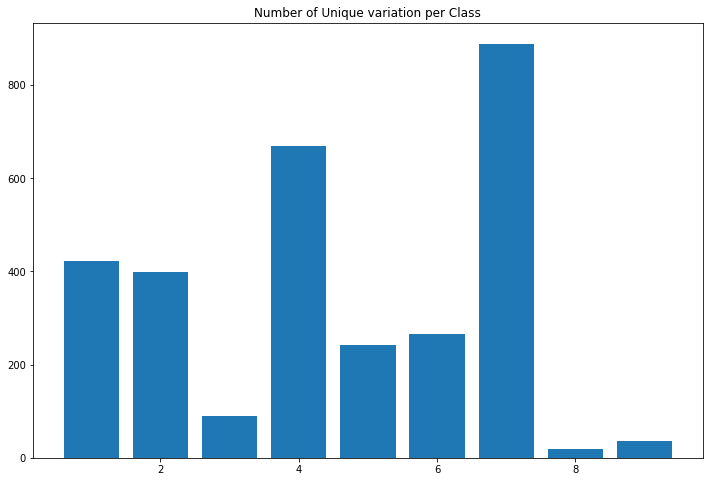

In [134]:
plt.figure(figsize=(12,8))
plt.bar(unique_var_count.keys(),unique_var_count.values())
plt.title('Number of Unique variation per Class')
plt.show()

### 3.7 Unique variation per Gene 

In [135]:
unique_gene_variation={}
for gene in unique_genes:
    data=train.loc[train.Gene==gene]
    unique_gene_variation[gene]=data.Variation.unique()
print (unique_gene_variation)
print (len(unique_gene_variation))

{'CDK12': array(['Y901C', 'K975E', 'Deletion', 'R882L', 'W719*', 'K765R', 'L996F',
       'G909R', 'Truncating Mutations', 'D887N'], dtype=object), 'RET': array(['RET-CCDC6 Fusion', 'A883T', 'C609Y', 'T338I', 'C634R', 'S891A',
       'E632_L633del', 'C618R', 'C611Y', 'K603Q', 'D631G', 'E921K',
       'Fusions', 'S904F', 'L790F', 'R873Q', 'Y806C', 'S765P', 'V804L',
       'R897Q', 'D631A', 'A883F', 'C634S', 'A919V', 'C634W', 'M980T',
       'E768D', 'KIF5B-RET Fusion', 'R833C', 'V804M', 'M918V', 'C630R',
       'V648I', 'I852M', 'C620R', 'C634Y', 'V804G', 'R886W', 'F893L',
       'Y791F'], dtype=object), 'FLT1': array(['Amplification'], dtype=object), 'RUNX1': array(['R177*', 'Y113*', 'R139G', 'K83N', 'R177Q', 'R166Q', 'P173S',
       'R201Q', 'S70fsX93', 'W279*', 'Truncating Mutations', 'R174*',
       'D171G', 'Amplification', 'RUNX1-EVI1 Fusion', 'TEL-RUNX1 Fusion',
       'H78Q', 'G42R', 'RUNX1-RUNX1T1 Fusion', 'D171N', 'A122*',
       'Fusions', 'R80C', 'K83E'], dtype=object), 'BAR

** 3.7.1 Number Of Unique Variations Per Gene**

In [136]:
unique_gene_variation_count={}
for key, value in sorted(unique_gene_variation.items()):
         unique_gene_variation_count[key]= len(value)
print (unique_gene_variation_count)
print (max(unique_gene_variation_count.values()))

{'ABL1': 26, 'ACVR1': 3, 'AGO2': 5, 'AKT1': 28, 'AKT2': 11, 'AKT3': 4, 'ALK': 69, 'APC': 5, 'AR': 20, 'ARAF': 7, 'ARID1A': 1, 'ARID1B': 2, 'ARID2': 2, 'ARID5B': 1, 'ASXL1': 1, 'ASXL2': 1, 'ATM': 6, 'ATR': 1, 'ATRX': 2, 'AURKA': 3, 'AURKB': 1, 'AXIN1': 1, 'AXL': 1, 'B2M': 6, 'BAP1': 9, 'BARD1': 1, 'BCL10': 2, 'BCL2': 1, 'BCL2L11': 2, 'BCOR': 5, 'BRAF': 93, 'BRCA1': 264, 'BRCA2': 125, 'BRD4': 2, 'BRIP1': 7, 'BTK': 3, 'CARD11': 12, 'CARM1': 3, 'CASP8': 6, 'CBL': 25, 'CCND1': 13, 'CCND2': 1, 'CCND3': 7, 'CCNE1': 2, 'CDH1': 9, 'CDK12': 10, 'CDK4': 3, 'CDK6': 2, 'CDK8': 1, 'CDKN1A': 3, 'CDKN1B': 4, 'CDKN2A': 52, 'CDKN2B': 7, 'CDKN2C': 1, 'CEBPA': 1, 'CHEK2': 7, 'CIC': 5, 'CREBBP': 7, 'CTCF': 5, 'CTLA4': 1, 'CTNNB1': 25, 'DDR2': 9, 'DICER1': 9, 'DNMT3A': 3, 'DNMT3B': 2, 'DUSP4': 1, 'EGFR': 141, 'EIF1AX': 1, 'ELF3': 6, 'EP300': 9, 'EPAS1': 8, 'EPCAM': 1, 'ERBB2': 69, 'ERBB3': 11, 'ERBB4': 20, 'ERCC2': 19, 'ERCC3': 2, 'ERCC4': 6, 'ERG': 4, 'ERRFI1': 1, 'ESR1': 16, 'ETV1': 3, 'ETV6': 8, 'EWSR1':

**3.7.2 Plot of number of Unique variations per Gene**

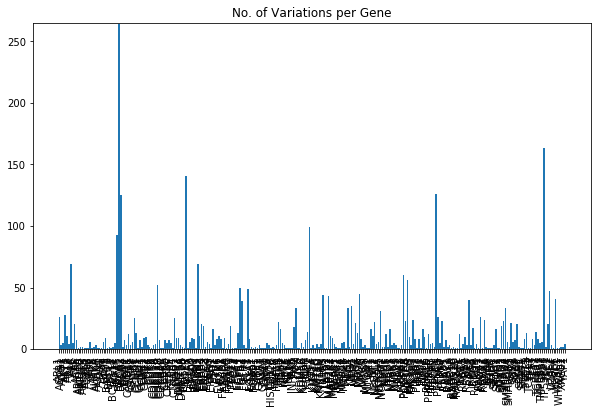

In [139]:
plt.figure(figsize= (10,6))
x=np.arange(len(unique_gene_variation_count))
plt.bar(x,unique_gene_variation_count.values(),align='center')
plt.xticks(x,unique_gene_variation_count.keys(),rotation=90)
ymax=max(unique_gene_variation_count.values())+1
plt.ylim(0,ymax)

plt.title("No. of Variations per Gene")

plt.show()

**Inference** : Out of 264 unique genes values in training data, 104 genes occur in a class of mutation.

### 3.8 Unique Gene Per Variation 

In [140]:
unique_variation_gene={}
for variation in unique_variation:
    data=train.loc[train.Variation==variation]
    unique_variation_gene[variation]=data.Gene.unique()
print (unique_variation_gene)

{'D24Y': array(['PTEN'], dtype=object), 'P2476L': array(['MTOR'], dtype=object), 'G101W': array(['CDKN2A'], dtype=object), 'R110L': array(['TP53'], dtype=object), 'E839K': array(['KIT'], dtype=object), 'Exon 20 insertions/deletions': array(['ERBB2'], dtype=object), 'R268A': array(['SMAD3'], dtype=object), 'A532H': array(['SMAD4'], dtype=object), 'Q22K': array(['HRAS', 'KRAS'], dtype=object), 'Y1248F': array(['ERBB2'], dtype=object), 'Y16C': array(['PTEN'], dtype=object), 'D1067V': array(['PIK3CB'], dtype=object), 'W1038C': array(['JAK2'], dtype=object), 'L46F': array(['MAP2K2'], dtype=object), 'M232T': array(['MYD88'], dtype=object), 'K1452N': array(['MTOR'], dtype=object), 'T507K': array(['PTPN11'], dtype=object), 'G1202R': array(['ALK'], dtype=object), 'P287S': array(['CCND1'], dtype=object), 'D816H': array(['KIT'], dtype=object), 'S196N': array(['BRCA2'], dtype=object), 'A111P': array(['MLH1'], dtype=object), 'I49S': array(['CDKN2A'], dtype=object), 'Hypermethylation': array(['CDKN2

**3.8.1 No of Unique Gene per variation**

In [141]:
unique_variation_gene_count={}
for key, value in sorted(unique_variation_gene.items()):
         unique_variation_gene_count[key]= len(value)
print (unique_variation_gene_count)

{'1_2009trunc': 1, '2010_2471trunc': 1, '256_286trunc': 1, "3' Deletion": 1, '385_418del': 1, '422_605trunc': 1, '533_534del': 1, '534_536del': 1, '550_592del': 1, '560_561insER': 1, '596_619splice': 1, '963_D1010splice': 1, '981_1028splice': 1, 'A1020V': 1, 'A1022E': 1, 'A1065T': 1, 'A1066V': 1, 'A1099T': 1, 'A111P': 1, 'A1131T': 1, 'A113_splice': 1, 'A1170V': 1, 'A11_G12insGA': 1, 'A1200V': 1, 'A120S': 1, 'A121E': 1, 'A121P': 1, 'A121V': 1, 'A122*': 1, 'A1234T': 1, 'A126D': 1, 'A126G': 1, 'A126S': 1, 'A126V': 1, 'A134D': 1, 'A1374V': 1, 'A1459P': 1, 'A146T': 2, 'A146V': 2, 'A148T': 1, 'A149P': 1, 'A1519T': 1, 'A151T': 1, 'A159T': 1, 'A161S': 1, 'A161T': 1, 'A1669S': 1, 'A1685S': 1, 'A1701P': 1, 'A1708E': 1, 'A1708V': 1, 'A171V': 1, 'A1752P': 1, 'A1752V': 1, 'A1789S': 1, 'A1789T': 1, 'A1823T': 1, 'A1830T': 1, 'A1843P': 1, 'A1843T': 1, 'A18D': 1, 'A197T': 1, 'A19V': 1, 'A2034V': 1, 'A205T': 1, 'A209T': 1, 'A211D': 1, 'A232V': 1, 'A2351G': 1, 'A23E': 1, 'A2425T': 1, 'A246P': 1, 'A263V':

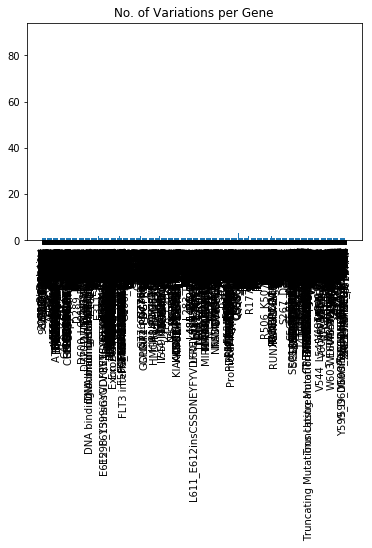

In [143]:
plt.figure()
x=np.arange(len(unique_variation_gene_count))
plt.bar(x,unique_variation_gene_count.values(),align='center')
plt.xticks(x,unique_variation_gene_count.keys(),rotation=90)
ymax=max(unique_variation_gene_count.values())+1
plt.ylim(0,ymax)

plt.title("No. of Variations per Gene")

plt.show()

**Inference **  :  From this plot we can conclude that most of the variation per gene is having value as 1.

### 3.9 Scatter Plot For Gene-Variation 

In [146]:
# number of unique genes
print ("the number of unique genes =", len(unique_genes))

the number of unique genes = 264


In [147]:
# assigning unique numbers for each unique genes
number_gene={}
ctr=1
for i in set(unique_genes):
    number_gene[ctr]=i
    ctr=ctr+1

In [148]:
# assigning unique numbers for each unique variation
number_variation={}
ctr=1
for i in set(unique_variation):
    number_variation[ctr]=i
    ctr=ctr+1

In [149]:
# creating a new dataframe with the numerical values
import pandas as pd
dfnum_traino=train.copy(deep=True)
#for gene

for index, row in dfnum_traino.iterrows():
    for j in dict(number_gene):
        if(row['Gene']==number_gene[j]):
            dfnum_traino.loc[index,'Gene']=j

In [150]:
#for variation   

for index, row in dfnum_traino.iterrows():
    for j in dict(number_variation):
        if(row['Variation']==number_variation[j]):
            dfnum_traino.loc[index,'Variation']=j                
print (dfnum_traino)

        ID  Gene  Variation  Class  \
0        0   153       2476      1   
1        1    52       2007      2   
2        2    52        380      2   
3        3    52       2267      3   
4        4    52        438      4   
5        5    52       2931      4   
6        6    52       1876      5   
7        7    52       1891      1   
8        8    52       1730      4   
9        9    52        751      4   
10      10    52       1707      4   
11      11    52       2537      4   
12      12    52        158      4   
13      13    52        254      4   
14      14    52       1273      5   
15      15    52       1588      4   
16      16    52       2476      1   
17      17    52       2556      4   
18      18    52       1535      5   
19      19    52       1553      4   
20      20    52       2770      6   
21      21    52       1492      4   
22      22    52        584      4   
23      23    52       2702      4   
24      24    52       1338      4   
25      25  

In [151]:
dfnum_traino.shape

(3321, 7)

<Figure size 14400x10800 with 0 Axes>

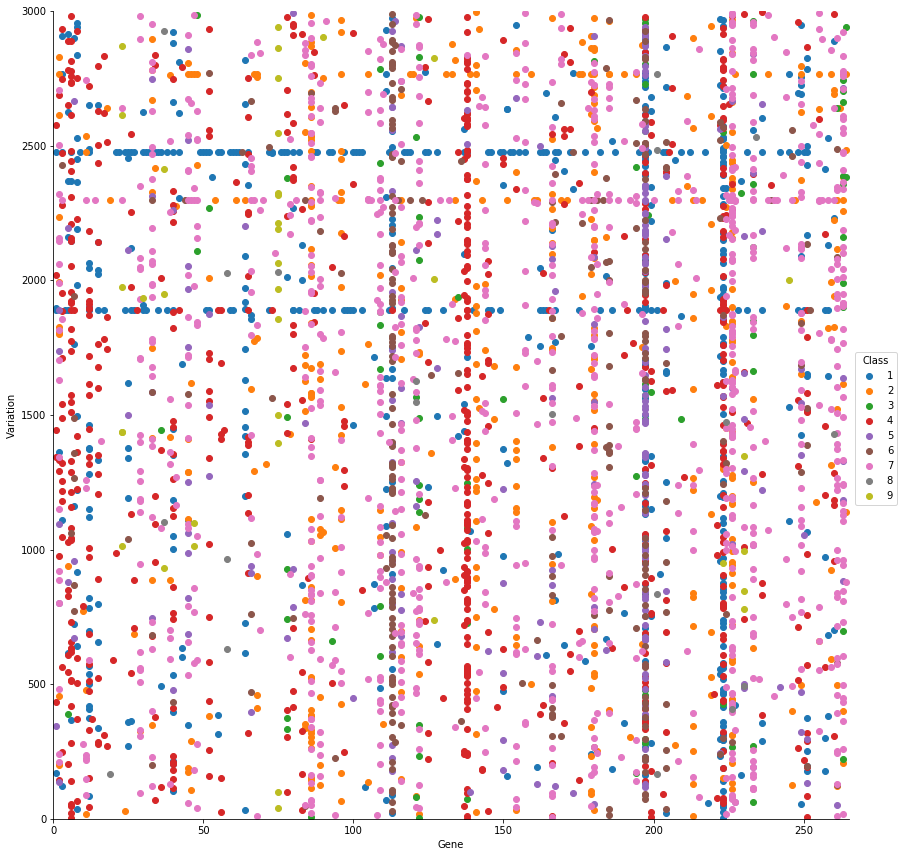

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(200,150))
sns.FacetGrid(dfnum_traino, hue="Class", size=12) \
   .map(plt.scatter, "Gene", "Variation") \
   .add_legend();
# sns.FacetGrid(dfnum_traino.loc[dfnum_traino['Class']==7], hue="Class", size=12) \
#    .map(plt.scatter, "Gene", "Variation") \
#    .add_legend();
plt.ylim(0, 3000)
plt.xlim(0,265)
plt.show();

**Inference from this plot** <br>
On a first look this plot gives nothing but a feel of randomness. But on careful observation, we can see that there are some verical as well as horizontal relationship existing here.

For instance Class 1 have almost every unique genes for a particular variation. Class 7 has almost every variation for a particular gene. We can find similar relation for class 4 as well.

We can see that class 7 dominates over most of the genes and variation

### 3.10 Pair-Plot Of the Features

In [153]:
dfnum_train2=dfnum_traino.copy(deep=True)

In [157]:
dfnum_train2.loc[:,'ClassName'] =dfnum_traino['Class'].astype(str)

In [ ]:
del dfnum_train2['Class']

In [159]:
dfnum_train2.head()

ID  Gene  Variation                                               TEXT  \
0   0   153       2476  cyclin dependent kinases cdks regulate variety...   
1   1    52       2007  abstract background non small cell lung cancer...   
2   2    52        380  abstract background non small cell lung cancer...   
3   3    52       2267  recent evidence demonstrated acquired uniparen...   
4   4    52        438  oncogenic mutations monomeric casitas b lineag...   

   LenText  Text_count ClassName  
0    30836        4370         1  
1    27844        4139         2  
2    27844        4139         2  
3    28093        3841         3  
4    31649        4254         4

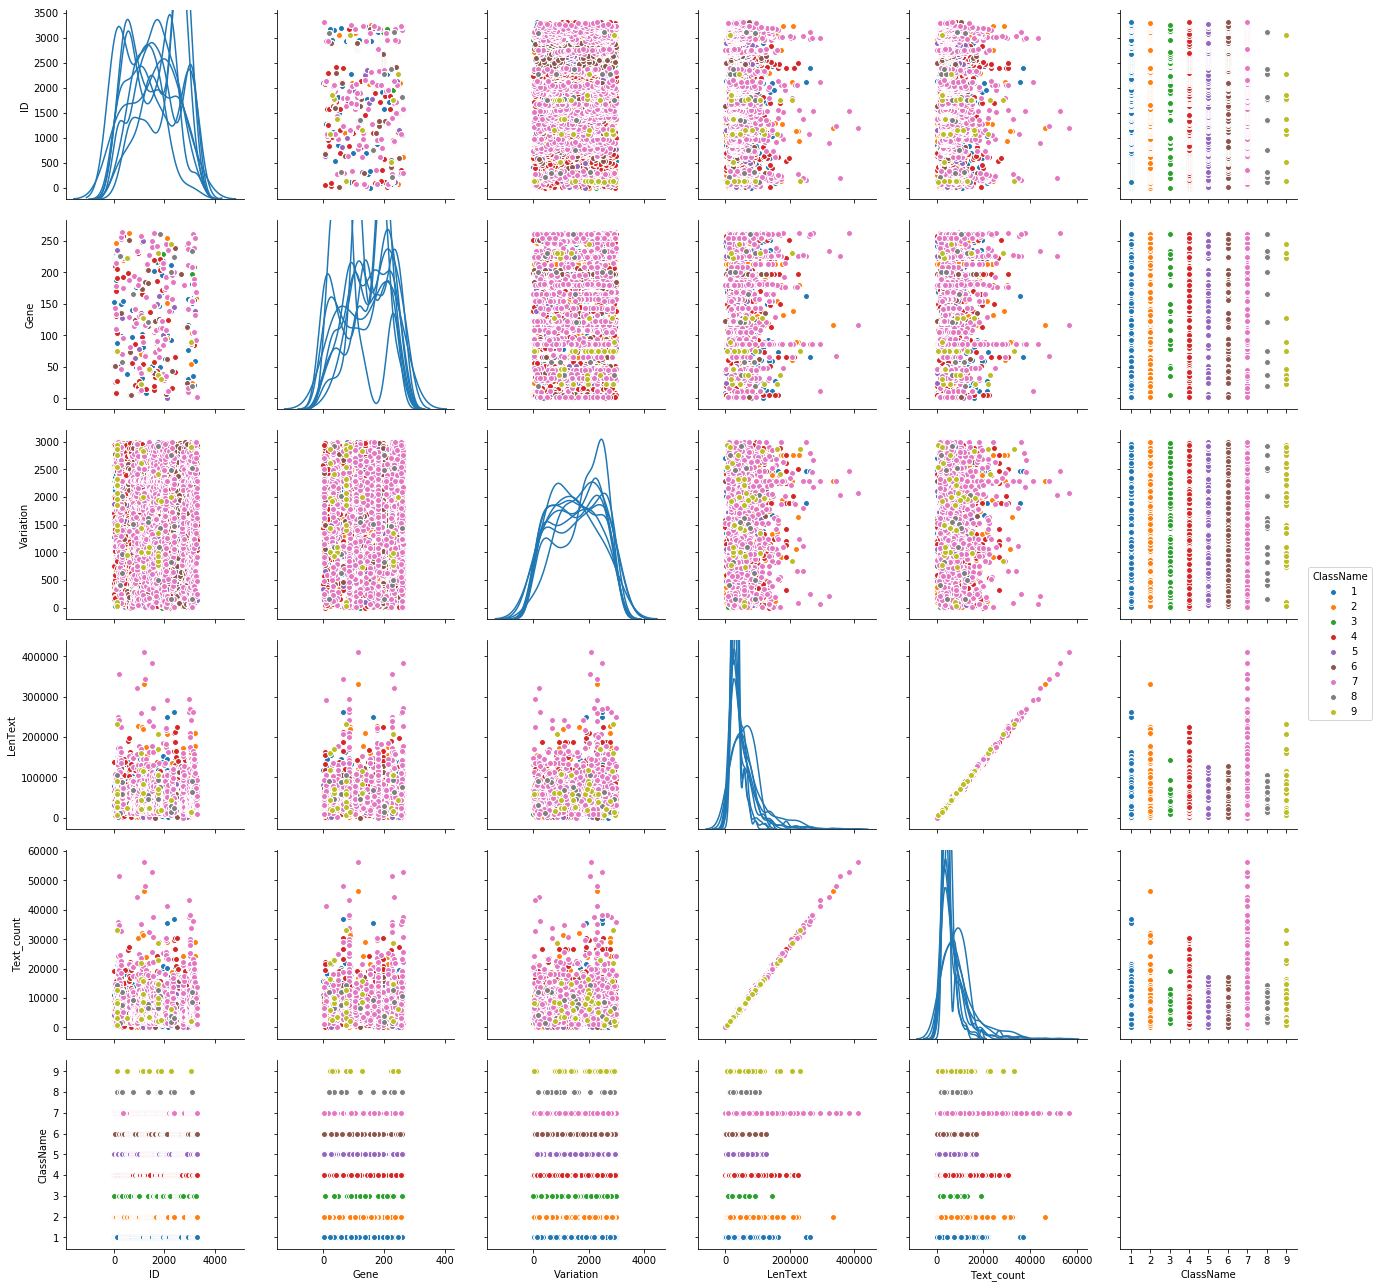

In [161]:
sns.pairplot(dfnum_train2, hue="ClassName", size=3, diag_kind="kde");
plt.show()

### 3.11 Genes Dominating in every class

In [163]:
#checking max occurance of genes
gene_group = train.groupby("Gene")['Gene'].count()
print (gene_group.sort_values(ascending=False)[:15])

Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
PIK3CA     56
CDKN2A     52
FGFR2      50
FLT3       49
TSC2       47
Name: Gene, dtype: int64


#### Top dominating genes for Class 1 

In [164]:
train1=train[train.Class==1]
gene_group = train1.groupby("Gene")['Gene'].count()
cls1=gene_group.sort_values(ascending=False)[:10]
print (cls1)

Gene
TP53     83
BRCA1    60
TSC2     23
BRCA2    18
ERCC2    17
VHL      15
SMAD4    13
PTPRT    13
SMAD3    11
SMAD2    11
Name: Gene, dtype: int64


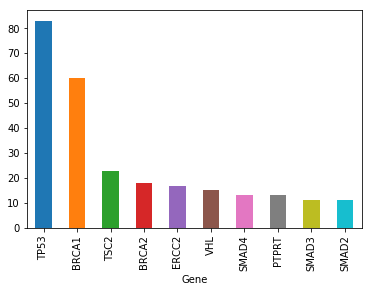

In [165]:
cls1.plot(kind='bar')

#### Top dominating genes for Class 2

In [167]:
train2=train[train.Class==2]
gene_group = train2.groupby("Gene")['Gene'].count()
cls2=gene_group.sort_values(ascending=False)[:10]
print (cls2)

Gene
EGFR      45
KIT       44
BRAF      31
ABL1      24
ROS1      18
HRAS      15
PDGFRB    14
ERBB2     14
PIK3CA    14
NOTCH1    13
Name: Gene, dtype: int64


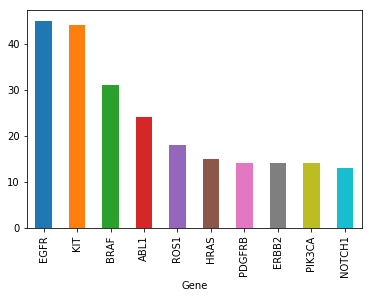

In [168]:
cls2.plot(kind='bar')

#### Top dominating genes for Class 3

In [169]:
train3=train[train.Class==3]
gene_group = train3.groupby("Gene")['Gene'].count()
cls3=gene_group.sort_values(ascending=False)[:10]
print (cls3)

Gene
BRCA1      15
MTOR       11
ALK        10
PDGFRA      9
FLT3        7
TSC1        6
PTEN        5
ERBB4       3
AKT1        3
TMPRSS2     2
Name: Gene, dtype: int64


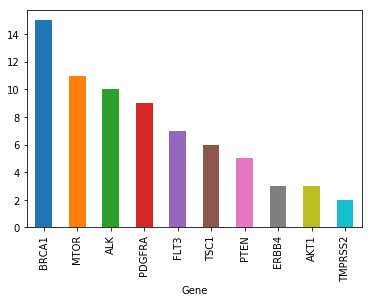

In [170]:
cls3.plot(kind='bar')

#### Top dominating genes for Class 4 

In [171]:
train4=train[train.Class==4]
gene_group = train4.groupby("Gene")['Gene'].count()
cls4=gene_group.sort_values(ascending=False)[:10]
print (cls4)

Gene
PTEN      115
TP53       67
CDKN2A     47
BRCA1      46
TSC2       23
VHL        23
CBL        16
RUNX1      16
PIK3R1     15
SPOP       15
Name: Gene, dtype: int64


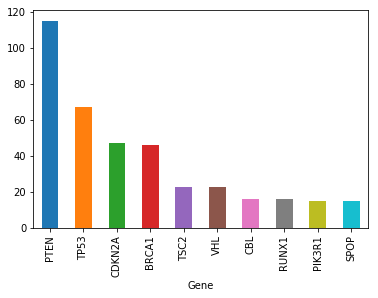

In [172]:
cls4.plot(kind='bar')

#### Top dominating genes for Class 5

In [173]:
train5=train[train.Class==5]
gene_group = train5.groupby("Gene")['Gene'].count()
cls5=gene_group.sort_values(ascending=False)[:10]
print (cls5)

Gene
BRCA1     90
BRCA2     20
FGFR3     10
BRAF       8
PIK3CA     8
MLH1       6
ERBB2      6
IDH1       6
FGFR2      5
PMS2       5
Name: Gene, dtype: int64


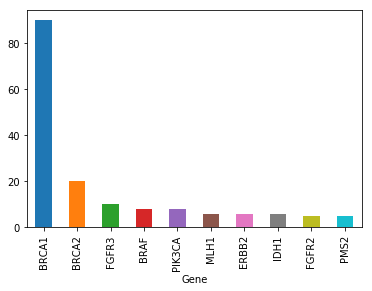

In [174]:
cls5.plot(kind='bar')

#### Top dominating genes for Class 6

In [175]:
train6=train[train.Class==6]
gene_group = train6.groupby("Gene")['Gene'].count()
cls6=gene_group.sort_values(ascending=False)[:10]
print (cls6)

Gene
BRCA2    84
BRCA1    53
JAK2     14
ERBB2    12
MLH1     11
TET2      6
TP53      5
KRAS      4
PIM1      4
ERBB4     4
Name: Gene, dtype: int64


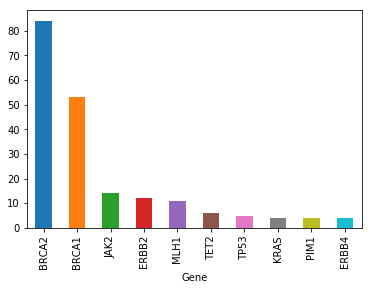

In [177]:
cls6.plot(kind='bar')

#### Top dominating genes for Class 7 

In [178]:
train7=train[train.Class==7]
gene_group = train7.groupby("Gene")['Gene'].count()
cls7=gene_group.sort_values(ascending=False)[:10]
print (cls7)

Gene
EGFR      84
KIT       52
BRAF      48
ALK       47
PDGFRA    42
FLT3      37
KRAS      33
PIK3CA    31
ERBB2     30
FGFR2     27
Name: Gene, dtype: int64


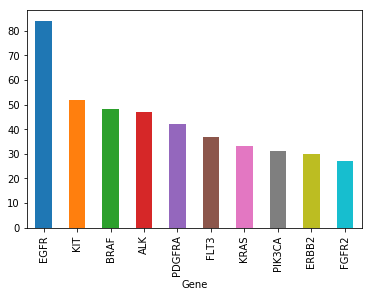

In [179]:
cls7.plot(kind='bar')

#### Top dominating genes for Class 8

In [180]:
train8=train[train.Class==8]
gene_group = train8.groupby("Gene")['Gene'].count()
cls8=gene_group.sort_values(ascending=False)[:10]
print (cls8)

Gene
BCOR      4
H3F3A     3
IDH2      2
AKT1      2
SF3B1     1
RHOA      1
RAD51B    1
PTPN11    1
IDH1      1
ERBB2     1
Name: Gene, dtype: int64


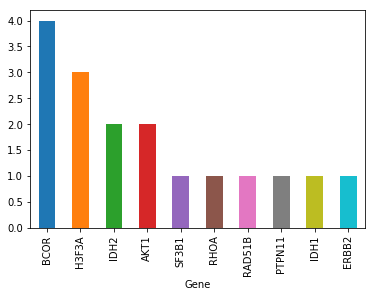

In [181]:
cls8.plot(kind='bar')

#### Top dominating genes for Class 9

In [182]:
train9=train[train.Class==9]
gene_group = train9.groupby("Gene")['Gene'].count()
cls9=gene_group.sort_values(ascending=False)[:10]
print (cls9)

Gene
SF3B1    15
EZH2      6
IDH1      4
U2AF1     3
IDH2      3
AKT2      2
TP53      1
MED12     1
CTCF      1
CIC       1
Name: Gene, dtype: int64


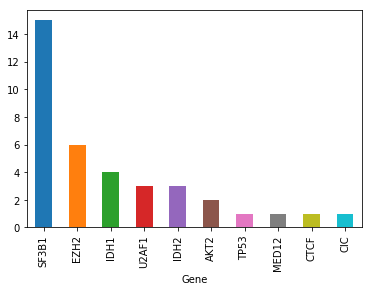

In [183]:
 cls9.plot(kind='bar')

# 4.Preprocessing Of Text

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', '  ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(str(row['TEXT']), index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 185.343006 seconds


In [6]:
#Merging both gene variation and text data based on ID
result = pd.merge (data, data_text, on = 'ID', how = 'left' )
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

## 4.1 Test, Train and Cross Validation Split

### 4.1.1 Splitting data into train, test and cross validation 

In [7]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [8]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


### 4.1.2 Distribution of y_i's in Train, Test and Cross Validation datasets

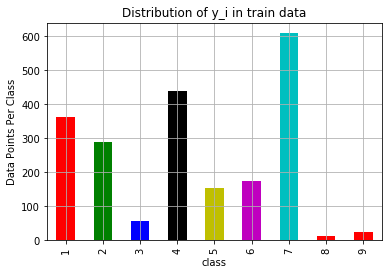

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


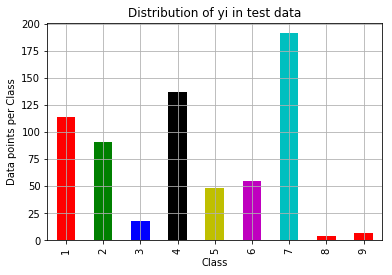

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


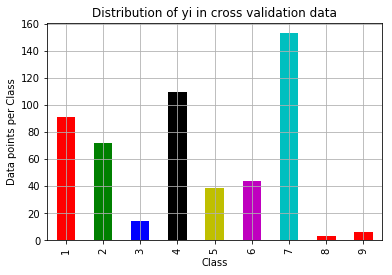

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [9]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = ['r','g','b','k','y','m','c']
train_class_distribution.plot(kind = 'bar' , color = my_colors)
plt.xlabel('class')
plt.ylabel('Data Points Per Class')
plt.title('Distribution of y_i in train data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    

print('-'*80)
my_colors = ['r','g','b','k','y','m','c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = ['r','g','b','k','y','m','c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


-  So, Here we are dealing with a multiclass classification problem with imbalanced data.<br>
-  From the above plots, we infer that the train ,test and cross validate data have similar distribution of class labels.

## 4.2 Predict Using a Random Models

In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

In [10]:
#Plots Confusion Matrix given Y_i and y_i_hat
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.528557224443801
Log loss on Test Data using Random Model 2.491381854798291
-------------------- Confusion matrix --------------------


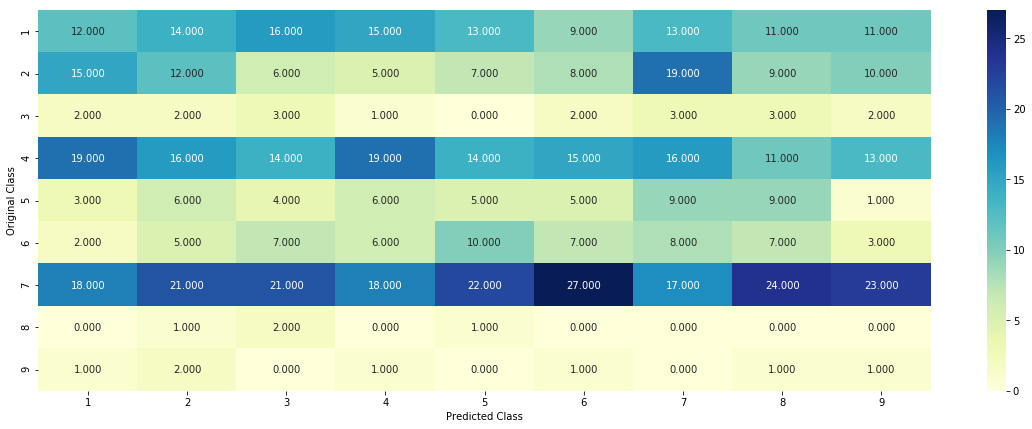

-------------------- Precision matrix (Columm Sum=1) --------------------


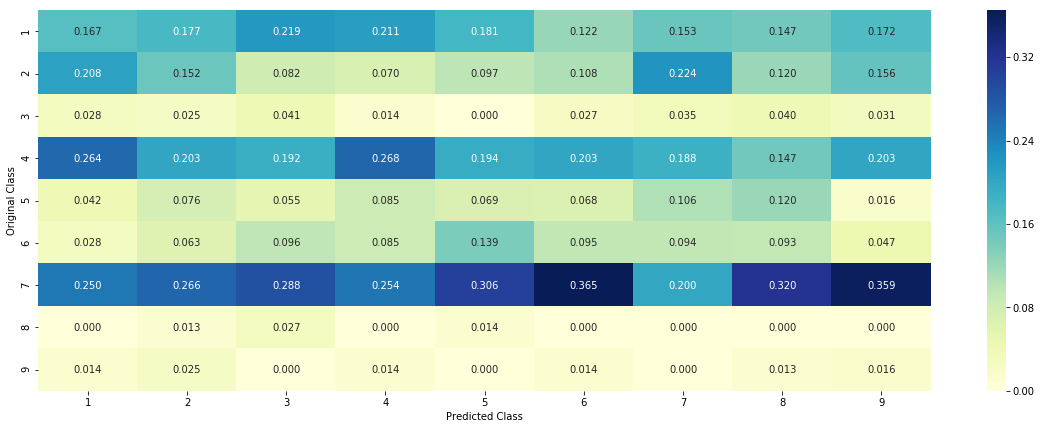

-------------------- Recall matrix (Row sum=1) --------------------


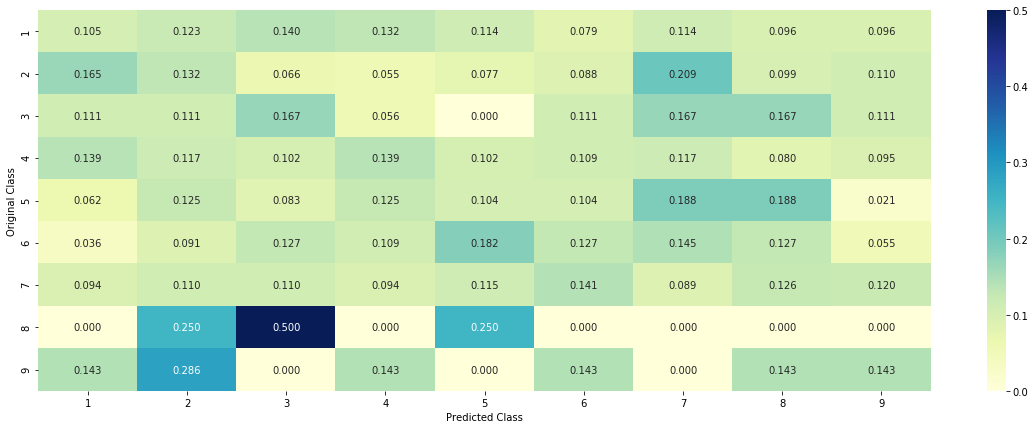

In [11]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

#Cross-Validate error
#we create an output array that has exactly same size as the CV Data.
cv_predicted_y = np.zeros((cv_data_len , 9))
for i in range (cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps = 1e-15))

# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)


## 4.3 Univariate Analysis  

In [12]:
# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea


when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing

 - (numerator + 10 * alpha) / (denominator + 90 * alpha)

### 4.3.1 Univariate Analysis On Gene Feature

Gene is a Categorical feature and we need to see how many categories are there and how are they distributed.

In [13]:
unique_genes = train_df['Gene'].value_counts()
print('No of unique Genes :' , unique_genes.shape[0])
print(unique_genes.head(10))

No of unique Genes : 236
BRCA1     166
TP53       98
EGFR       88
PTEN       86
BRCA2      83
KIT        64
BRAF       54
ERBB2      49
ALK        38
PIK3CA     36
Name: Gene, dtype: int64


 - There are  237  different categories of genes in the train data and they are distributed as follows <br>

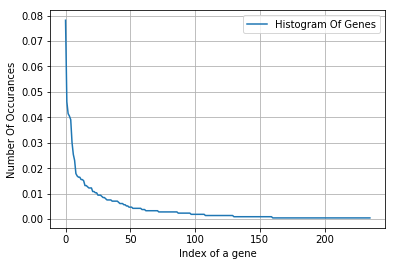

In [14]:
s = sum(unique_genes.values)
h = unique_genes.values / s
plt.plot(h , label = 'Histogram Of Genes')
plt.xlabel('Index of a gene')
plt.ylabel('Number Of Occurances')
plt.legend()
plt.grid()
plt.show()

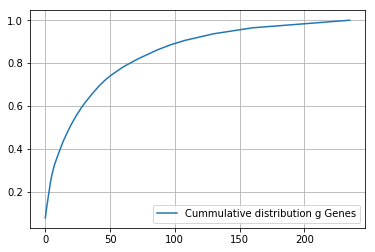

In [15]:
c = np.cumsum(h)
plt.plot(c ,label = 'Cummulative distribution g Genes')
plt.grid()
plt.legend()
plt.show()

There are two ways to featurize this variable<br>
 1. One Hot Encoding
 2. Response Coding


In [16]:
#Response Coding For Gene Feature
alpha = 1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha , "Gene" , train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha , "Gene" , test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha , "Gene" , cv_df))

In [17]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature : \n", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature : 
 (2124, 9)


In [18]:
# one-hot encoding of Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [19]:
train_df['Gene'].head()

2820     BRCA2
25         CBL
1180    PIK3CA
368      EPAS1
1034      TSC2
Name: Gene, dtype: object

In [20]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',

In [21]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: \n", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: 
 (2124, 235)


Now we need to find, how good is the gene feature in predicting y_i. So, We build a proper Machine Learning Model using just this feature. In this case, a logistic regression model using just Gene feature (one hot encoded) is built to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.3804498613476697
For values of alpha =  0.0001 The log loss is: 1.2175916071708777
For values of alpha =  0.001 The log loss is: 1.2450881724543446
For values of alpha =  0.01 The log loss is: 1.407861510971218
For values of alpha =  0.1 The log loss is: 1.49134178301958
For values of alpha =  1 The log loss is: 1.5052382265622337


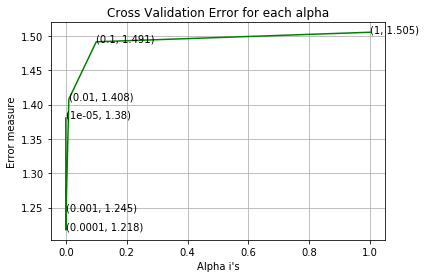

For values of best alpha =  0.0001 The train log loss is: 1.023034963102464
For values of best alpha =  0.0001 The cross validation log loss is: 1.2175916071708777
For values of best alpha =  0.0001 The test log loss is: 1.236819980359756


In [22]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Now, we need to figure out if the 'Gene' feature is stable across all datasets (Train , Test , Cross Validate)<br>
It seems like 'gene' feature is stable across all datasets, otherwise, the CV and Test errors would be significantly more than train error. But we need to be sure.

In [23]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 650 out of 665 : 97.74436090225564
2. In cross validation data 517 out of  532 : 97.18045112781954


So, Yes. 'Gene feature' is stable across all datasets.

### 4.3.2 Univariate Analysis On Variation Feature


Variation is a Categorical feature and we need to see how many categories are there and how are they distributed.

In [24]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations : 1926
Truncating_Mutations    57
Deletion                49
Amplification           45
Fusions                 19
Overexpression           6
Q61L                     3
Q61H                     3
E17K                     3
Q61R                     3
Y64A                     2
Name: Variation, dtype: int64


There are 1933 different categories of variations in the train data, and they are distibuted as follows :

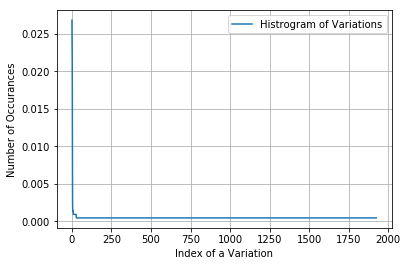

In [25]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02683616 0.04990584 0.07109228 ... 0.99905838 0.99952919 1.        ]


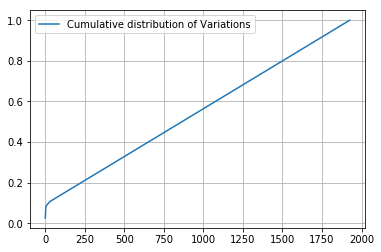

In [26]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Now, Featurizing the 'Variation Feature'

In [27]:
#Response Coding of Variation feature
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [28]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [29]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [30]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1959)


Now we need to find, how good is the 'Variation' feature in predicting y_i. So, We build a proper Machine Learning Model using just this feature. In this case, a logistic regression model using just Gene feature (one hot encoded) is built to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.6966253544205914
For values of alpha =  0.0001 The log loss is: 1.6803663963243012
For values of alpha =  0.001 The log loss is: 1.682965393623712
For values of alpha =  0.01 The log loss is: 1.6960038622265377
For values of alpha =  0.1 The log loss is: 1.7109496017992047
For values of alpha =  1 The log loss is: 1.7114875213464489


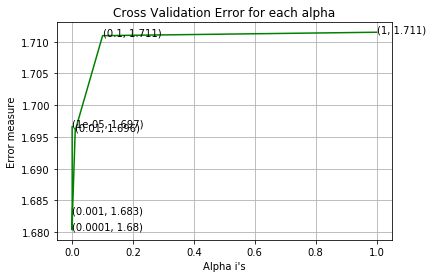

For values of best alpha =  0.0001 The train log loss is: 0.7676016045460451
For values of best alpha =  0.0001 The cross validation log loss is: 1.6803663963243012
For values of best alpha =  0.0001 The test log loss is: 1.7154916507283424


In [31]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Now, we need to figure out if the 'Variation' feature is stable across all datasets (Train , Test , Cross Validate)
So, checking for stability of this feature across all datasets.

In [32]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1926  genes in test and cross validation data sets?
1. In test data 61 out of 665 : 9.172932330827068
2. In cross validation data 60 out of  532 : 11.278195488721805


So, Variation Feature is less stable in predicting y_i.

### 4.3.3  Univariate Analysis on Text Feature

In [33]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [34]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [35]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53517


In [36]:
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [37]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [38]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [39]:
#Normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [40]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [41]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.015999578827051546: 322, 0.030804142487804526: 236, 0.06699524354907727: 201, 0.02189259001164371: 165, 0.3036438314502125: 154, 0.25019611287822907: 131, 0.014663677932481599: 123, 0.047454186304332985: 122, 0.04184403247454018: 117, 0.02302410595569306: 115, 0.05013854563150569: 110, 0.05995076942226038: 103, 0.05096862976456263: 102, 0.010492279432665662: 101, 0.06831674459469686: 100, 0.02181415104678511: 97, 0.04377546410231134: 95, 0.033192621195089235: 94, 0.10085490832496884: 88, 0.03593708333347323: 88, 0.02153440834076926: 85, 0.03675473742019735: 83, 0.011979678937689283: 80, 0.02324410630676641: 79, 0.05469111397425971: 78, 0.017282780052572017: 77, 0.016251094345961697: 77, 0.02683580774242257: 71, 0.021750921389572776: 70, 0.06046344241972615: 68, 0.03639086951074169: 66, 0.036670534681682014: 65, 0.025210401224678915: 65, 0.039187526496690134: 64, 0.019538648523017964: 64, 0.060248829645669334: 63, 0.023380574292579764: 63, 0.008004109895365995: 63, 0.01207380

For values of alpha =  1e-05 The log loss is: 1.3432142383289103
For values of alpha =  0.0001 The log loss is: 1.307878488516763
For values of alpha =  0.001 The log loss is: 1.2109187162406787
For values of alpha =  0.01 The log loss is: 1.2789230822374065
For values of alpha =  0.1 The log loss is: 1.350885114358761
For values of alpha =  1 The log loss is: 1.6018100405255873


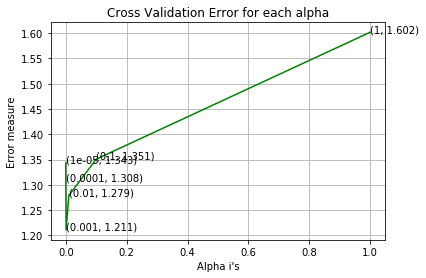

For values of best alpha =  0.001 The train log loss is: 0.6688669795668052
For values of best alpha =  0.001 The cross validation log loss is: 1.2109187162406787
For values of best alpha =  0.001 The test log loss is: 1.1750505019556114


In [42]:
# Train a Logistic regression+Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


It seems like the text feature is stable across all datasets but we lets be sure.

In [43]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [44]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.7 % of word of test data appeared in train data
98.122 % of word of Cross Validation appeared in train data


# 4. Machine Learning Models

In [45]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [46]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [47]:
# this function will be used just for naive bayes
# for the given indices, It will print the name of the features
# and will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## 4.0 Stacking the three types of features

In [48]:
# merging gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [49]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55711)
(number of data points * number of features) in test data =  (665, 55711)
(number of data points * number of features) in cross validation data = (532, 55711)


In [50]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## 4.1 Base Line Model

### 4.1.1 Naive Bayes

#### 4.1.1.1 Hyperparameter Tuning

for alpha = 1e-05
Log Loss : 1.2835559269831
for alpha = 0.0001
Log Loss : 1.2795129136527876
for alpha = 0.001
Log Loss : 1.2760112574081073
for alpha = 0.1
Log Loss : 1.2611825959592629
for alpha = 1
Log Loss : 1.2889091399802408
for alpha = 10
Log Loss : 1.3552618997032633
for alpha = 100
Log Loss : 1.2815396072282823
for alpha = 1000
Log Loss : 1.2384460463756726


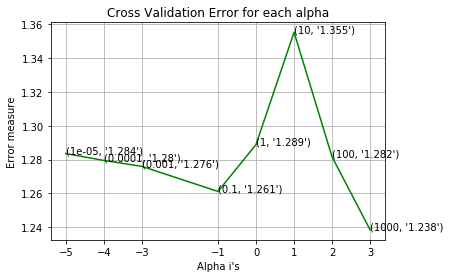

For values of best alpha =  1000 The train log loss is: 0.9091769605084987
For values of best alpha =  1000 The cross validation log loss is: 1.2384460463756726
For values of best alpha =  1000 The test log loss is: 1.2397538096852792


In [51]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### 4.1.1.2 Testing the model with best hyper parameters 

Log Loss : 1.2384460463756726
Number of missclassified point : 0.41353383458646614
-------------------- Confusion matrix --------------------


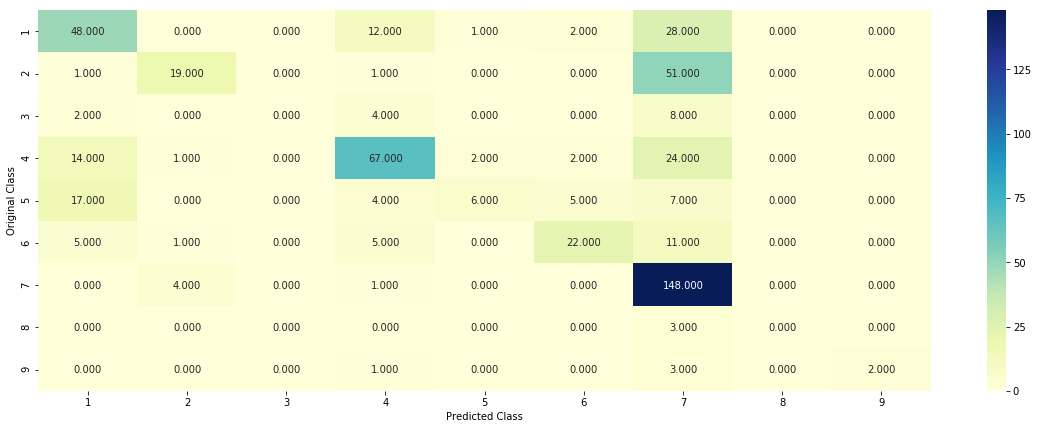

-------------------- Precision matrix (Columm Sum=1) --------------------


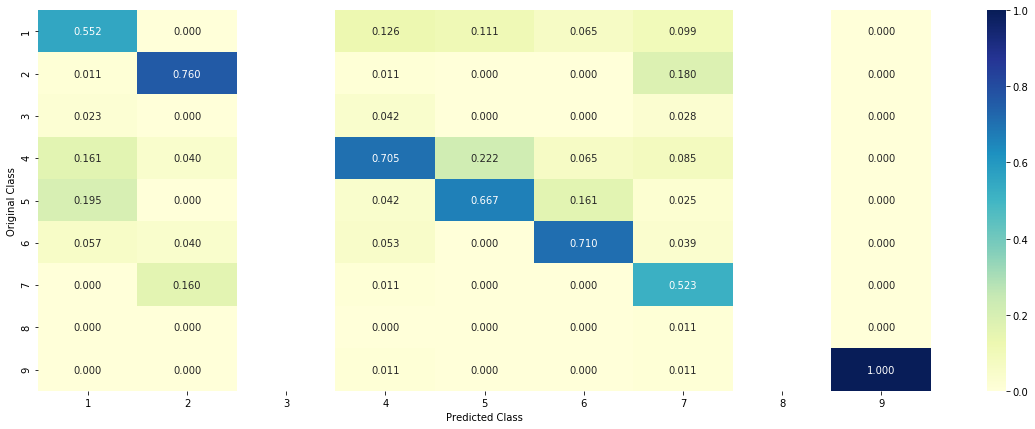

-------------------- Recall matrix (Row sum=1) --------------------


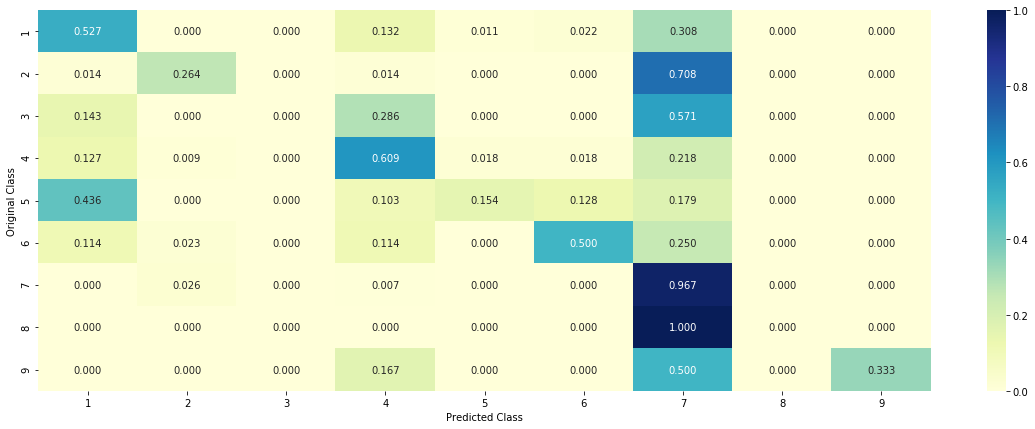

In [52]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### 4.1.1.3 Feature Importance, Correctly classified point 

In [53]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[4.028e-01 3.879e-01 2.700e-03 1.237e-01 1.320e-02 9.500e-03 5.920e-02
  7.000e-04 3.000e-04]]
Actual Class : 2
--------------------------------------------------
9 Text feature [protein] present in test data point [True]
10 Text feature [type] present in test data point [True]
11 Text feature [dna] present in test data point [True]
15 Text feature [one] present in test data point [True]
16 Text feature [wild] present in test data point [True]
17 Text feature [two] present in test data point [True]
18 Text feature [binding] present in test data point [True]
19 Text feature [therefore] present in test data point [True]
20 Text feature [containing] present in test data point [True]
21 Text feature [function] present in test data point [True]
22 Text feature [results] present in test data point [True]
23 Text feature [either] present in test data point [True]
24 Text feature [region] present in test data point [True]
25 Text feature [inv

#### 4.1.1.4 Feature Importance, Incorrectly classified point

In [54]:
test_point_index = 99
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0271 0.3874 0.0048 0.0314 0.0222 0.0353 0.4902 0.0009 0.0006]]
Actual Class : 6
--------------------------------------------------
14 Text feature [cells] present in test data point [True]
17 Text feature [downstream] present in test data point [True]
18 Text feature [cell] present in test data point [True]
19 Text feature [activation] present in test data point [True]
21 Text feature [kinase] present in test data point [True]
22 Text feature [factor] present in test data point [True]
23 Text feature [presence] present in test data point [True]
24 Text feature [expressing] present in test data point [True]
25 Text feature [contrast] present in test data point [True]
26 Text feature [shown] present in test data point [True]
27 Text feature [phosphorylation] present in test data point [True]
28 Text feature [also] present in test data point [True]
29 Text feature [signaling] present in test data point [True]
30 Text feature [inhibito

## 4.2 K Nearest Neighbour Classification

for alpha = 5
Log Loss : 1.0729025632469784
for alpha = 11
Log Loss : 1.0617809710165425
for alpha = 15
Log Loss : 1.0631949335627866
for alpha = 21
Log Loss : 1.0920327885927592
for alpha = 31
Log Loss : 1.1102154517441873
for alpha = 41
Log Loss : 1.118796549342645
for alpha = 51
Log Loss : 1.13365751907907
for alpha = 99
Log Loss : 1.1511425303439244


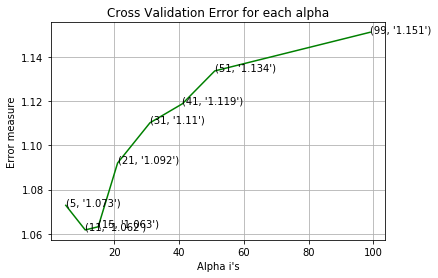

For values of best alpha =  11 The train log loss is: 0.6400932493905119
For values of best alpha =  11 The cross validation log loss is: 1.0617809710165425
For values of best alpha =  11 The test log loss is: 1.0682129778117233


In [55]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### 4.2.1 Testing the model with best hyper parameters

Log loss : 1.0617809710165425
Number of mis-classified points : 0.37969924812030076
-------------------- Confusion matrix --------------------


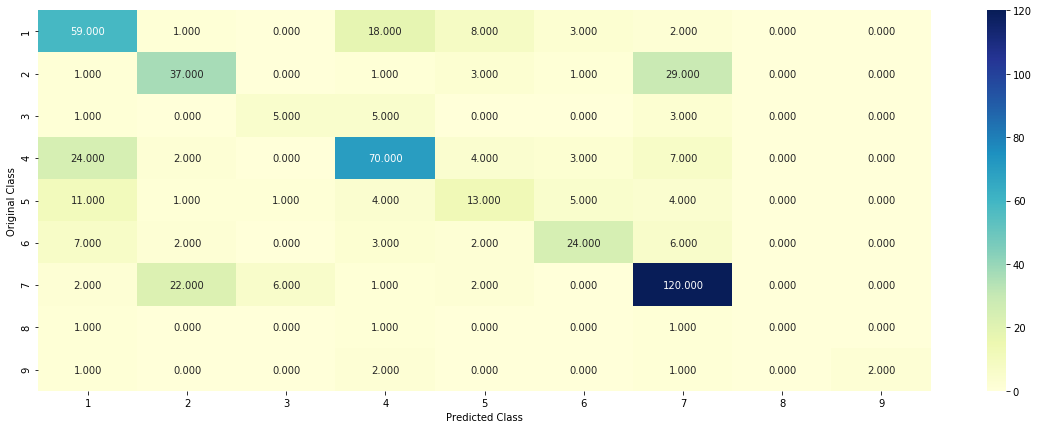

-------------------- Precision matrix (Columm Sum=1) --------------------


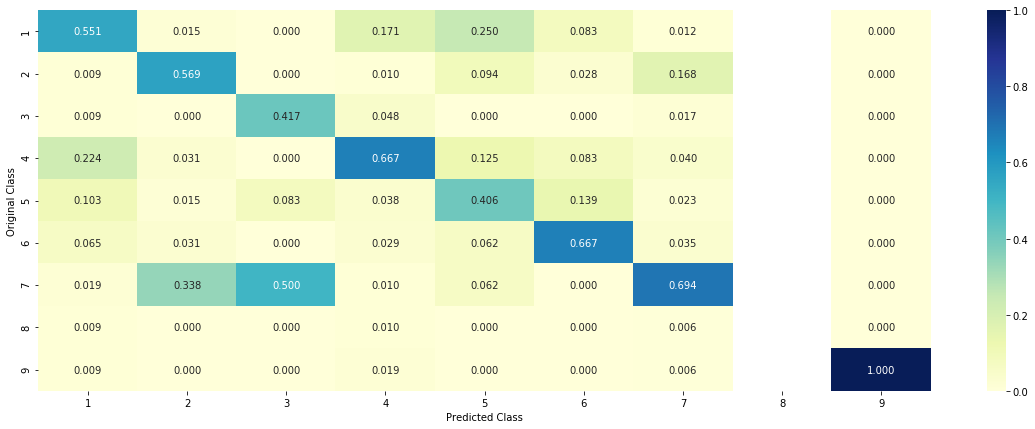

-------------------- Recall matrix (Row sum=1) --------------------


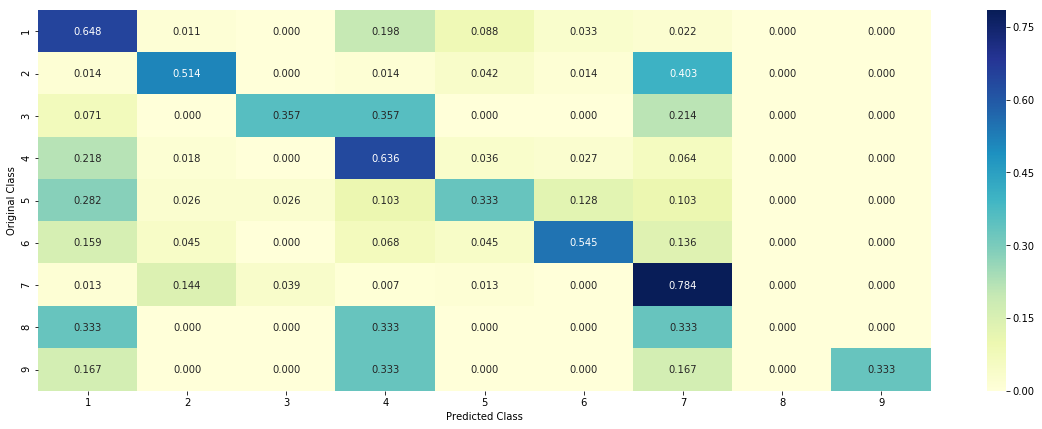

In [56]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#### 4.2.2 Feature Importance, Inorrectly classified point 

In [57]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 2
The  11  nearest neighbours of the test points belongs to classes [2 1 2 2 4 1 2 4 2 4 4]
Fequency of nearest points : Counter({2: 5, 4: 4, 1: 2})


#### 4.2.3 Feature Importance, Correctly classified point 

In [58]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [2 2 2 2 2 2 2 7 5 1 2]
Fequency of nearest points : Counter({2: 8, 7: 1, 5: 1, 1: 1})


## 4.3 Logistic Regression 

### 4.3.1 With Class Balancing 

#### 4.3.1.1 Hyperparameter Tuning

for alpha = 1e-06
Log Loss : 1.3681304209217964
for alpha = 1e-05
Log Loss : 1.335075733981027
for alpha = 0.0001
Log Loss : 1.271934925511442
for alpha = 0.001
Log Loss : 1.1151762564184002
for alpha = 0.01
Log Loss : 1.1789371939387605
for alpha = 0.1
Log Loss : 1.2849148537184965
for alpha = 1
Log Loss : 1.5078905359243384
for alpha = 10
Log Loss : 1.545377102619869
for alpha = 100
Log Loss : 1.5492953817180037


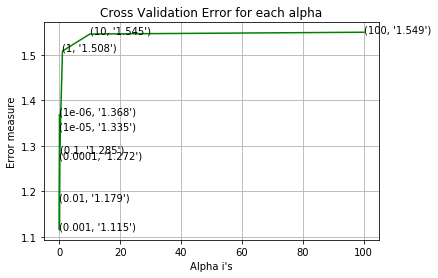

For values of best alpha =  0.001 The train log loss is: 0.5908530674733623
For values of best alpha =  0.001 The cross validation log loss is: 1.1151762564184002
For values of best alpha =  0.001 The test log loss is: 1.0962099932233333


In [59]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight= 'balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.3.1.2 Testing the mode with best Hyper Parameter

Log loss : 1.1151762564184002
Number of mis-classified points : 0.34022556390977443
-------------------- Confusion matrix --------------------


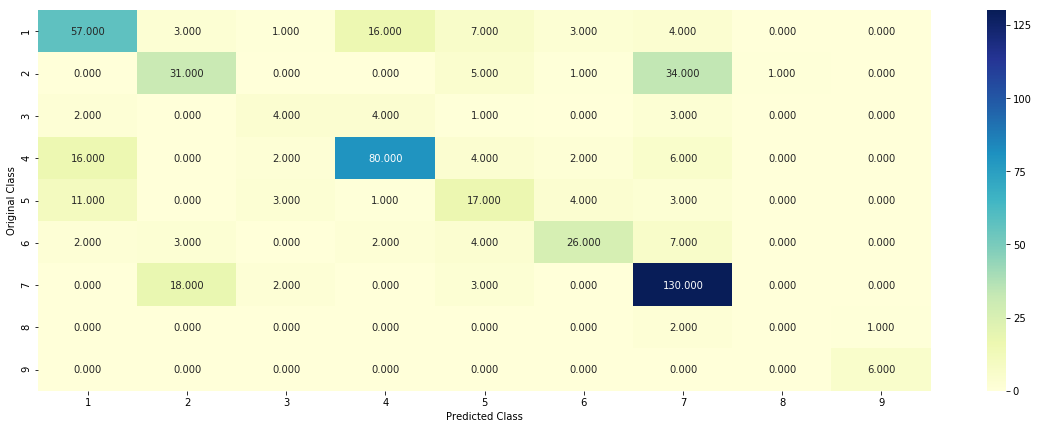

-------------------- Precision matrix (Columm Sum=1) --------------------


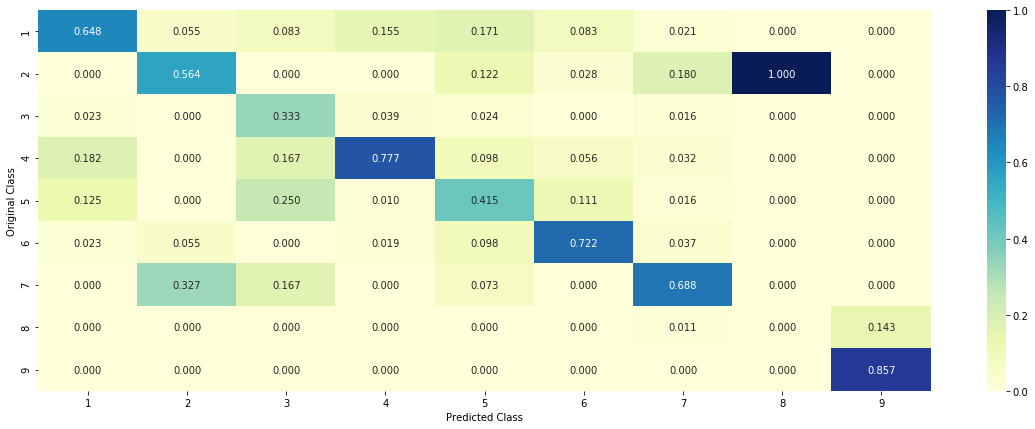

-------------------- Recall matrix (Row sum=1) --------------------


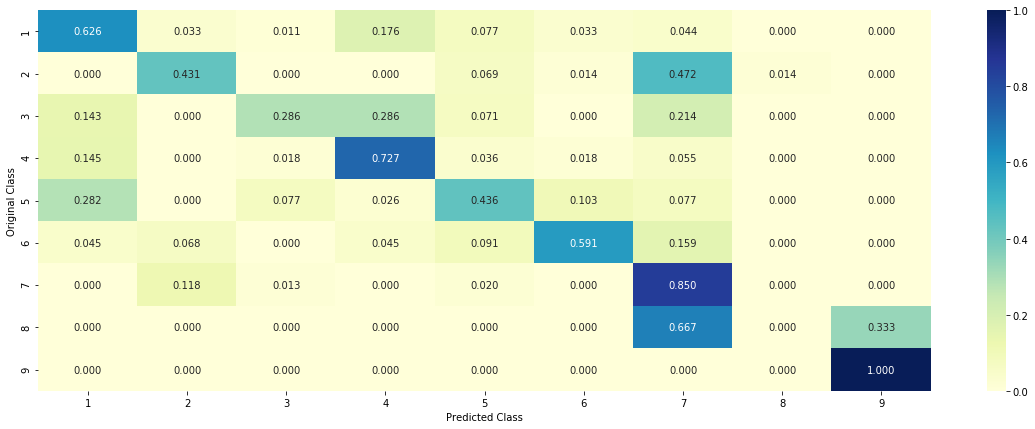

In [60]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.1.3 Feature Importance, correctly classified points

In [61]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 102
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0083 0.7049 0.005  0.0077 0.0077 0.0032 0.2572 0.0046 0.0013]]
Actual Class : 2
--------------------------------------------------
139 Text feature [4q12] present in test data point [True]
170 Text feature [therapy] present in test data point [True]
236 Text feature [chronic] present in test data point [True]
442 Text feature [performance] present in test data point [True]
443 Text feature [vulva] present in test data point [True]
496 Text feature [fused] present in test data point [True]
497 Text feature [advanced] present in test data point [True]
Out of the top  500  features  7 are present in query point


#### 4.3.1.4 Feature Importance, Incorrectly classified Points

In [62]:
test_point_index = 159
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.3772 0.1245 0.0175 0.1682 0.0359 0.0131 0.243  0.0154 0.0052]]
Actual Class : 4
--------------------------------------------------
286 Text feature [kin] present in test data point [True]
339 Text feature [ovaries] present in test data point [True]
400 Text feature [unilateral] present in test data point [True]
464 Text feature [creating] present in test data point [True]
Out of the top  500  features  4 are present in query point


### 4.3.2 Without Class Balancing 

#### 4.3.2.1 Hyperparameter Tuning

for alpha = 1e-06
Log Loss : 1.3244971312234601
for alpha = 1e-05
Log Loss : 1.2767493778401982
for alpha = 0.0001
Log Loss : 1.2883469794532147
for alpha = 0.001
Log Loss : 1.1442865433752718
for alpha = 0.01
Log Loss : 1.2078060935257506
for alpha = 0.1
Log Loss : 1.273865895578386
for alpha = 1
Log Loss : 1.494885466658595


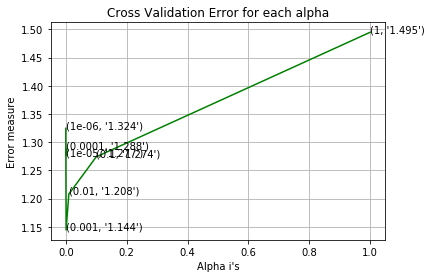

For values of best alpha =  0.001 The train log loss is: 0.5785887298861954
For values of best alpha =  0.001 The cross validation log loss is: 1.1442865433752718
For values of best alpha =  0.001 The test log loss is: 1.1103994210278727


In [63]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.3.2.2 Testing Model with Best parameters

Log loss : 1.1442865433752718
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


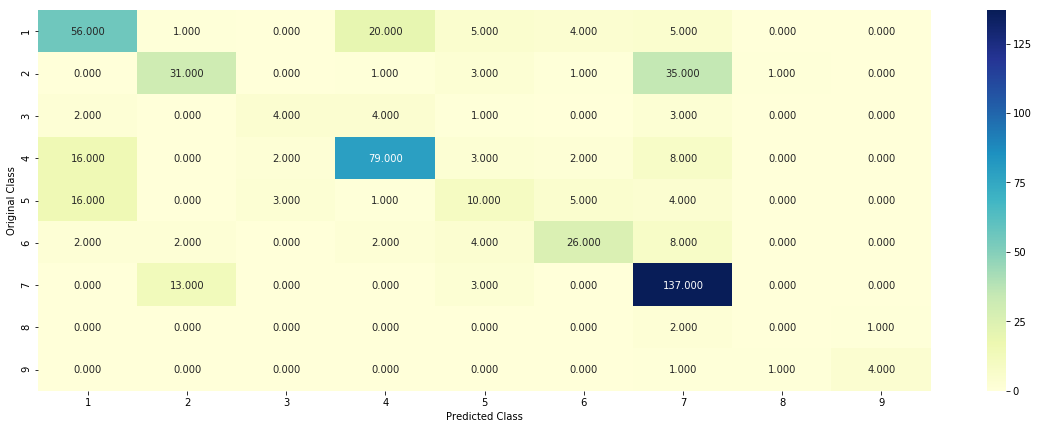

-------------------- Precision matrix (Columm Sum=1) --------------------


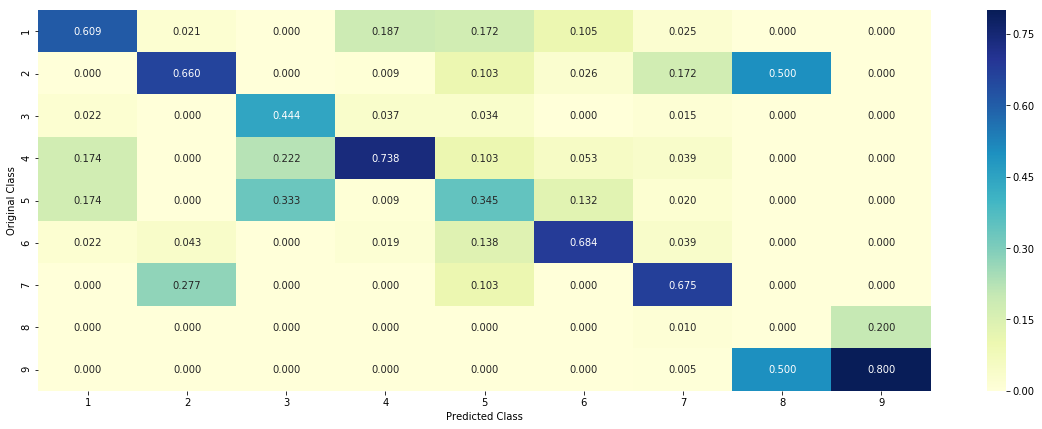

-------------------- Recall matrix (Row sum=1) --------------------


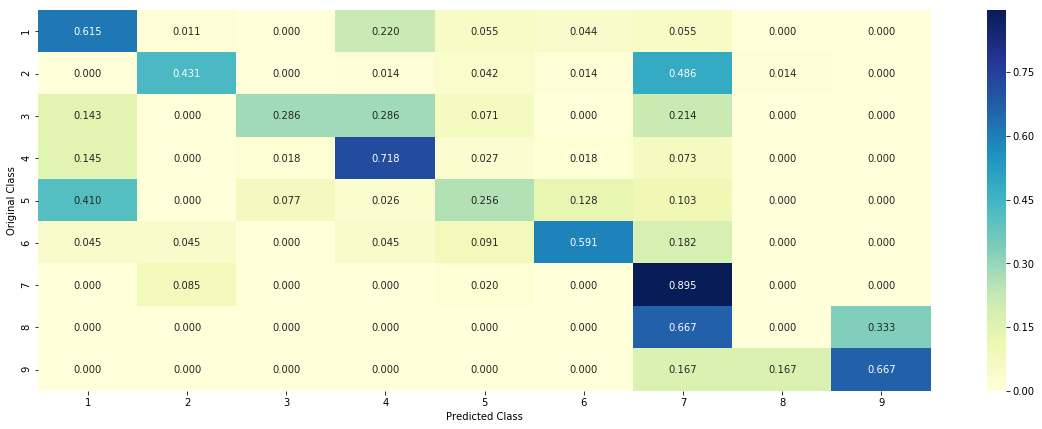

In [64]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.2.3 Feature Importance,Correctly Classified Points

In [65]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[6.151e-01 3.357e-01 5.000e-04 1.860e-02 3.100e-03 1.900e-03 2.460e-02
  4.000e-04 0.000e+00]]
Actual Class : 2
--------------------------------------------------
352 Text feature [exceeding] present in test data point [True]
381 Text feature [scaled] present in test data point [True]
433 Text feature [dcs] present in test data point [True]
459 Text feature [dbd] present in test data point [True]
Out of the top  500  features  4 are present in query point


#### 4.3.2.4 Feature Importance,Incorrectly Classified Points

In [66]:
test_point_index = 159
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[3.595e-01 1.254e-01 3.500e-03 1.802e-01 2.210e-02 9.300e-03 2.986e-01
  1.100e-03 3.000e-04]]
Actual Class : 4
--------------------------------------------------
286 Text feature [kin] present in test data point [True]
339 Text feature [ovaries] present in test data point [True]
400 Text feature [unilateral] present in test data point [True]
464 Text feature [creating] present in test data point [True]
Out of the top  500  features  4 are present in query point


## 4.4 Linear Support Vector Machines

#### 4.4.1Hyper Paramter Tuning 

for C = 1e-05
Log Loss : 1.3374121841030877
for C = 0.0001
Log Loss : 1.3169349374695167
for C = 0.001
Log Loss : 1.222574852494617
for C = 0.01
Log Loss : 1.1543973693698883
for C = 0.1
Log Loss : 1.2484048750671233
for C = 1
Log Loss : 1.5506900123262917
for C = 10
Log Loss : 1.5498206531295795
for C = 100
Log Loss : 1.5498088510721102


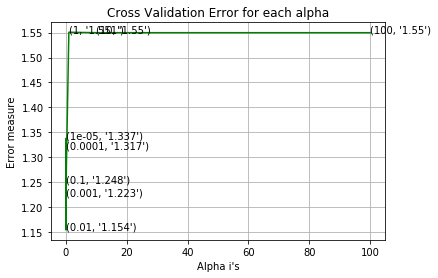

For values of best alpha =  0.01 The train log loss is: 0.7134145406892024
For values of best alpha =  0.01 The cross validation log loss is: 1.1543973693698883
For values of best alpha =  0.01 The test log loss is: 1.1891569067197618


In [67]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.4.2 Testing Model With Best Hyper parameters 

Log loss : 1.1543973693698883
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


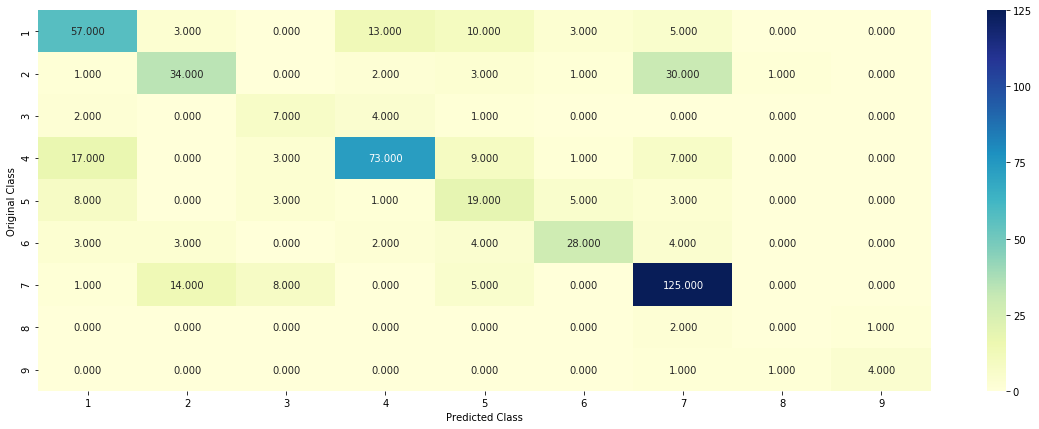

-------------------- Precision matrix (Columm Sum=1) --------------------


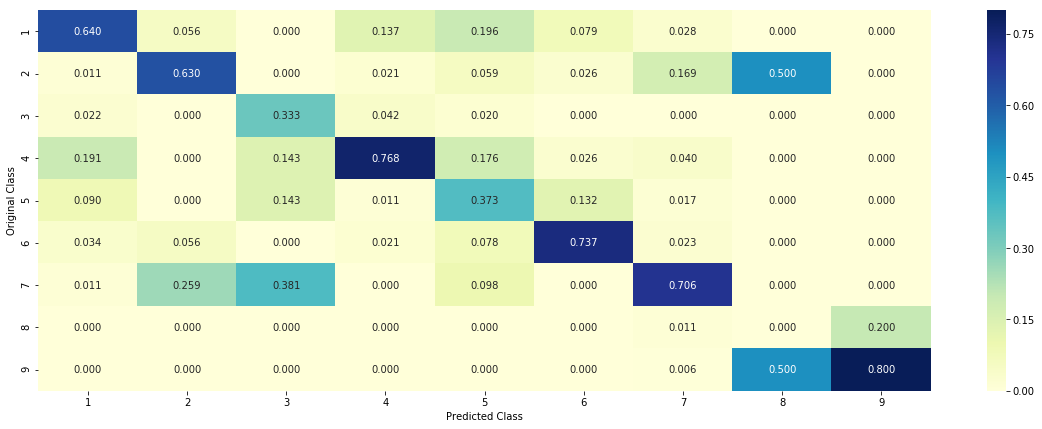

-------------------- Recall matrix (Row sum=1) --------------------


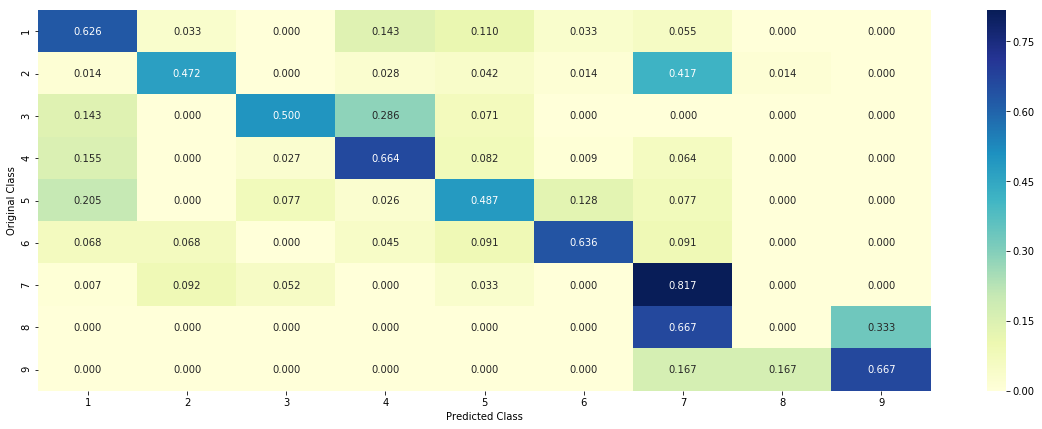

In [68]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### 4.4.3 Feature Importance for Correctly Classified points 

In [69]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 56
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1267 0.1704 0.0156 0.1272 0.0386 0.0344 0.4735 0.0067 0.007 ]]
Actual Class : 7
--------------------------------------------------
31 Text feature [serum] present in test data point [True]
37 Text feature [constitutively] present in test data point [True]
41 Text feature [technology] present in test data point [True]
43 Text feature [activation] present in test data point [True]
70 Text feature [perk1] present in test data point [True]
81 Text feature [jak] present in test data point [True]
101 Text feature [activating] present in test data point [True]
150 Text feature [constantly] present in test data point [True]
166 Text feature [bruton] present in test data point [True]
174 Text feature [jak3] present in test data point [True]
182 Text feature [factor] present in test data point [True]
191 Text feature [dimethylsulfoxide] present in test data point [True]
222 Text feature [facscanto] present in test data point [True]
225 Text 

#### 4.4.4 Feature Importance for Incorrectly Classified points

In [70]:
test_point_index = 105
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.9155 0.0137 0.0027 0.0278 0.0091 0.0044 0.0219 0.0033 0.0015]]
Actual Class : 1
--------------------------------------------------
33 Text feature [derepression] present in test data point [True]
198 Text feature [ortholog] present in test data point [True]
284 Text feature [paralog] present in test data point [True]
455 Text feature [archaebacterial] present in test data point [True]
Out of the top  500  features  4 are present in query point


## 4.5 Random Forest Classifier 

### 4.5.1 Hyper parameter Tuning (with One Hot Encoding )

In [71]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.3084967777995429
for n_estimators = 100 and max depth =  10
Log Loss : 1.2390653329256955
for n_estimators = 200 and max depth =  5
Log Loss : 1.292929980136524
for n_estimators = 200 and max depth =  10
Log Loss : 1.230749659702441
for n_estimators = 500 and max depth =  5
Log Loss : 1.2855055293977389
for n_estimators = 500 and max depth =  10
Log Loss : 1.221689697097865
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2800803115538277
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2162096249608543
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2789941837253314
for n_estimators = 2000 and max depth =  10
Log Loss : 1.218391447443366
For values of best estimator =  1000 The train log loss is: 0.667183426317342
For values of best estimator =  1000 The cross validation log loss is: 1.2162096249608543
For values of best estimator =  1000 The test log loss is: 1.196337703859502


#### 4.5.1.1 Testing Model With Best Hyperparameters

Log loss : 1.2162096249608543
Number of mis-classified points : 0.4116541353383459
-------------------- Confusion matrix --------------------


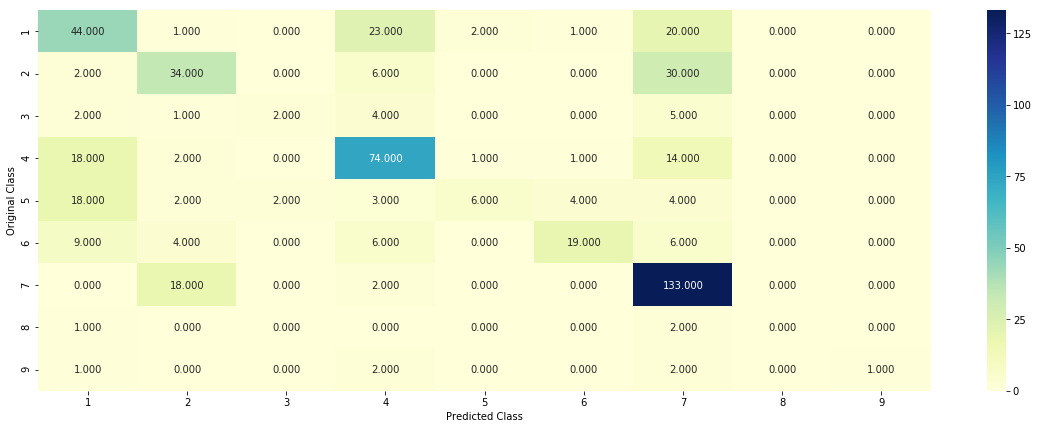

-------------------- Precision matrix (Columm Sum=1) --------------------


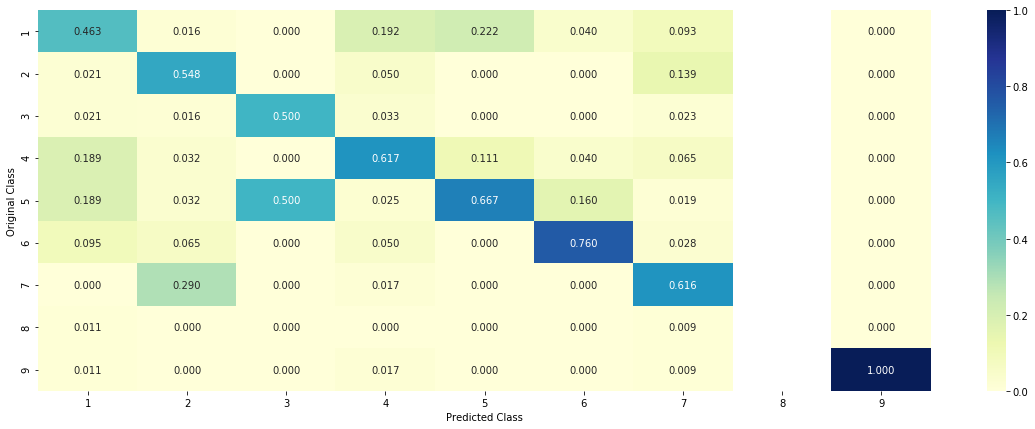

-------------------- Recall matrix (Row sum=1) --------------------


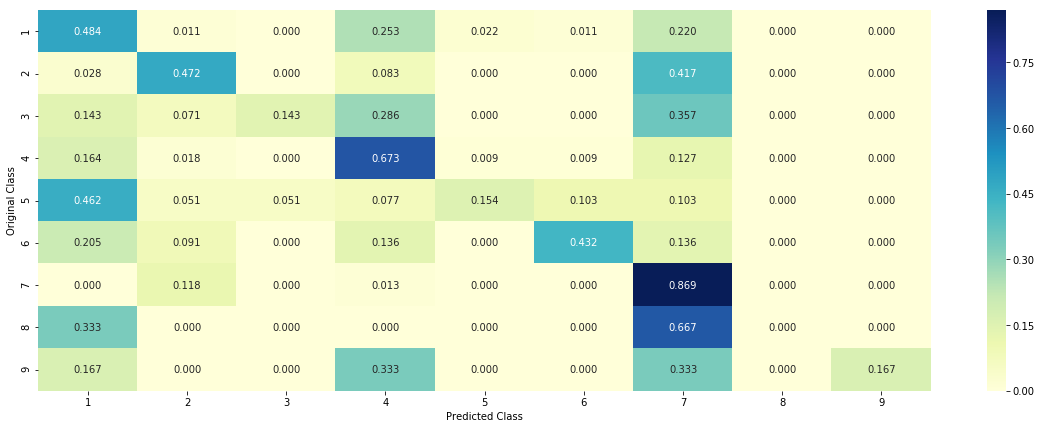

In [72]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### 4.5.1.2 Feature Importance for Correctly Classified Point

In [73]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 56
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0513 0.2888 0.0213 0.0475 0.045  0.037  0.4975 0.0048 0.0068]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [phosphorylation] present in test data point [True]
6 Text feature [tyrosine] present in test data point [True]
7 Text feature [inhibitor] present in test data point [True]
8 Text feature [activation] present in test data point [True]
10 Text feature [treatment] present in test data point [True]
11 Text feature [therapeutic] present in test data point [True]
13 Text feature [kinases] present in test data point [True]
14 Text feature [loss] present in test data point [True]
15 Text feature [signaling] present in test data point [True]
16 Text feature [akt] present in test data point [True]
17 Text feature [drug

#### 4.5.1.3 Feature Importance for Incorrectly Classified points

In [74]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0623 0.7256 0.0144 0.03   0.041  0.0265 0.0913 0.0036 0.0052]]
Actuall Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [phosphorylation] present in test data point [True]
4 Text feature [oncogenic] present in test data point [True]
5 Text feature [constitutive] present in test data point [True]
7 Text feature [inhibitor] present in test data point [True]
8 Text feature [activation] present in test data point [True]
9 Text feature [activated] present in test data point [True]
10 Text feature [treatment] present in test data point [True]
11 Text feature [therapeutic] present in test data point [True]
12 Text feature [nonsense] present in test data point [True]
14 Text feature [loss] present in test data point [True]
15 Text fea

### 4.5.2 Hyper paramter tuning (With Response Coding) 

In [75]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.118353389292588
for n_estimators = 10 and max depth =  3
Log Loss : 1.65794853230696
for n_estimators = 10 and max depth =  5
Log Loss : 1.3296439041501495
for n_estimators = 10 and max depth =  10
Log Loss : 2.0890732279883437
for n_estimators = 50 and max depth =  2
Log Loss : 1.7279834297137453
for n_estimators = 50 and max depth =  3
Log Loss : 1.4496495886705112
for n_estimators = 50 and max depth =  5
Log Loss : 1.3577126382354923
for n_estimators = 50 and max depth =  10
Log Loss : 1.7445001718799933
for n_estimators = 100 and max depth =  2
Log Loss : 1.5735491468033054
for n_estimators = 100 and max depth =  3
Log Loss : 1.4867613384160145
for n_estimators = 100 and max depth =  5
Log Loss : 1.30902910781283
for n_estimators = 100 and max depth =  10
Log Loss : 1.7548400531991588
for n_estimators = 200 and max depth =  2
Log Loss : 1.6378105463820438
for n_estimators = 200 and max depth =  3
Log Loss : 1.468982708314683
for

#### 4.5.2.1 Testing model with best hyper parameters (Response Coding)

Log loss : 1.3090291078128333
Number of mis-classified points : 0.4642857142857143
-------------------- Confusion matrix --------------------


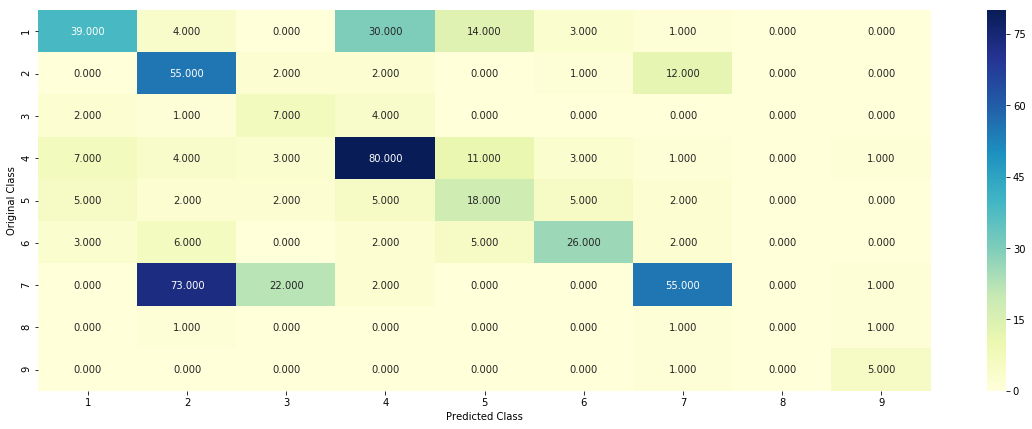

-------------------- Precision matrix (Columm Sum=1) --------------------


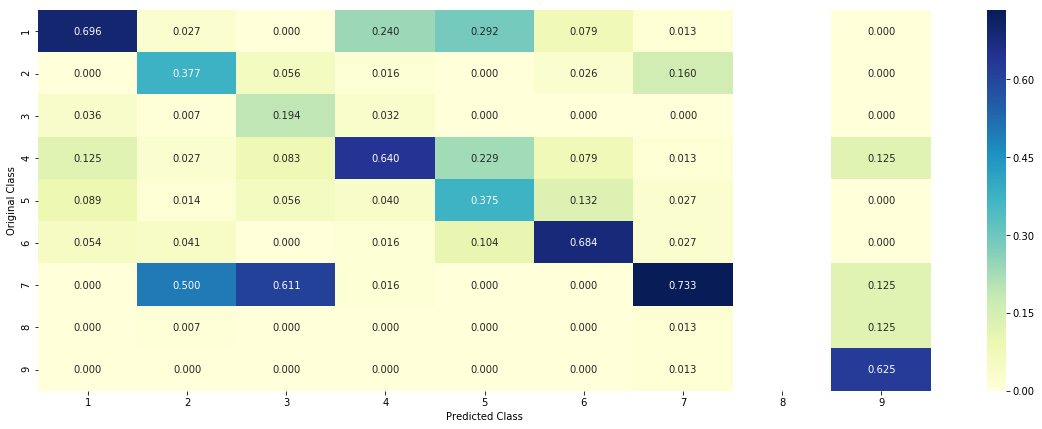

-------------------- Recall matrix (Row sum=1) --------------------


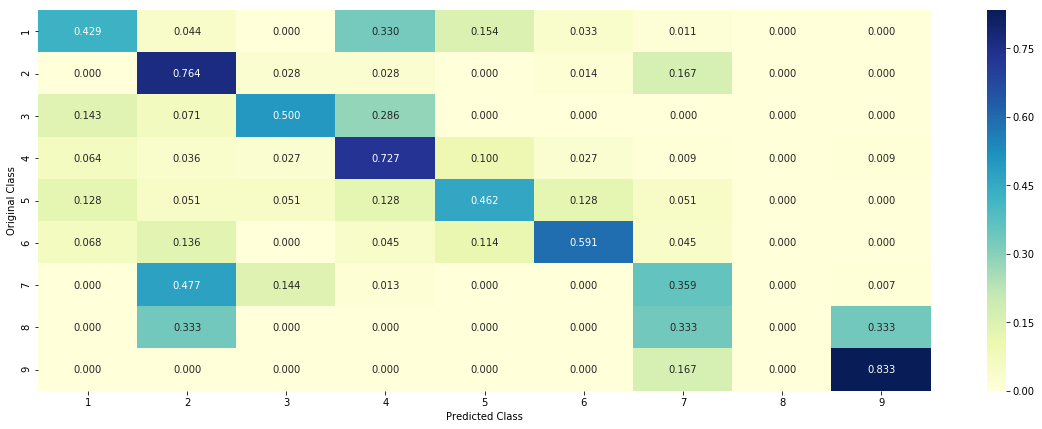

In [76]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

#### 4.5.2.2 Feature Importance for Correctly Classfied Point 

In [77]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 59
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0073 0.2875 0.345  0.0091 0.0129 0.0282 0.2895 0.0114 0.0093]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


#### 4.5.2.3 Feature importance for Incorrectly Classified Point

In [78]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0055 0.7756 0.0653 0.0076 0.0102 0.029  0.0913 0.0082 0.0075]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


## 4.6 Stacking The Models

### 4.6.1 Testing With Hyper Parameter Tuning 

In [79]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.12
Support vector machines : Log Loss: 1.55
Naive Bayes : Log Loss: 1.28
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.035
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.504
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.127
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.216
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.429


### 4.6.2 Testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.6489119297751261
Log loss (CV) on the stacking classifier : 1.1272031176581185
Log loss (test) on the stacking classifier : 1.14712188121874
Number of missclassified point : 0.3894736842105263
-------------------- Confusion matrix --------------------


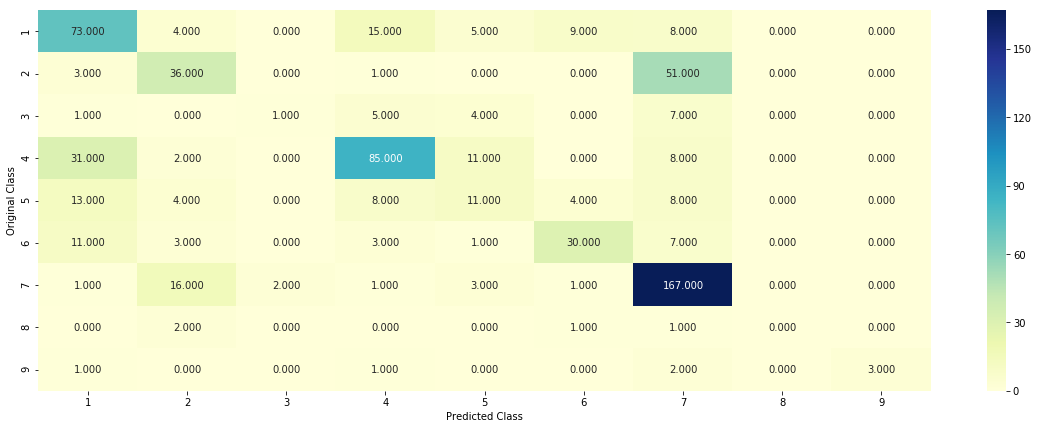

-------------------- Precision matrix (Columm Sum=1) --------------------


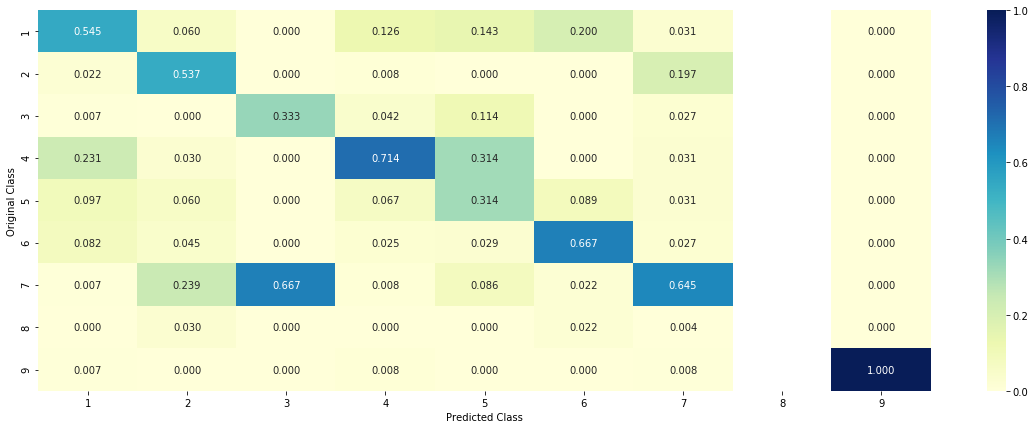

-------------------- Recall matrix (Row sum=1) --------------------


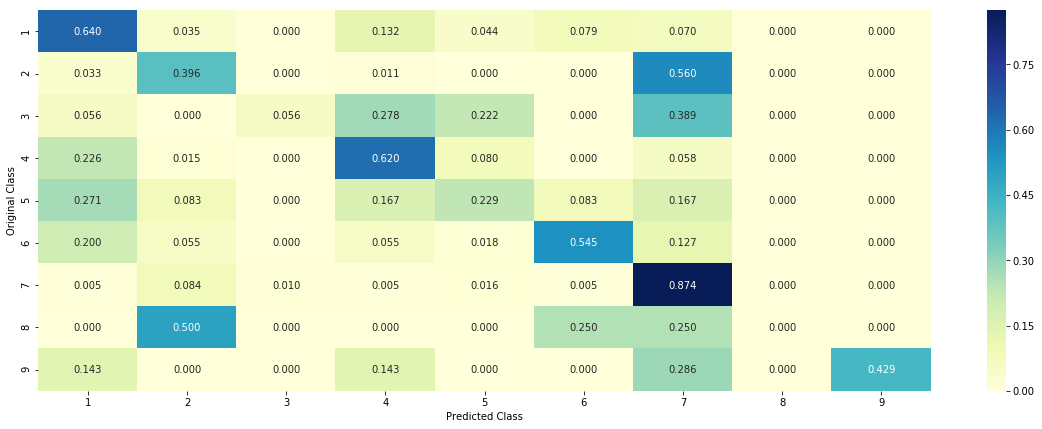

In [80]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## 4.7 Maximum Voting classifier 

Log loss (train) on the VotingClassifier : 0.8563008591153071
Log loss (CV) on the VotingClassifier : 1.15932721345914
Log loss (test) on the VotingClassifier : 1.204901120910159
Number of missclassified point : 0.3849624060150376
-------------------- Confusion matrix --------------------


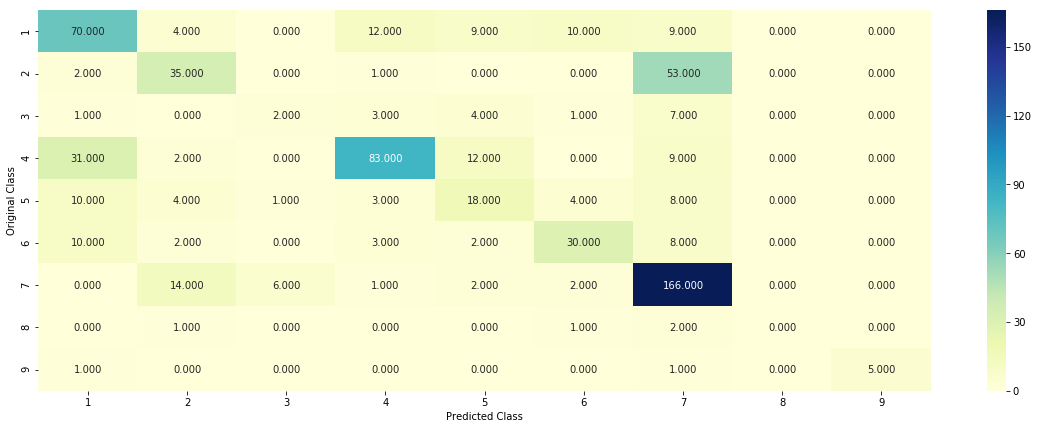

-------------------- Precision matrix (Columm Sum=1) --------------------


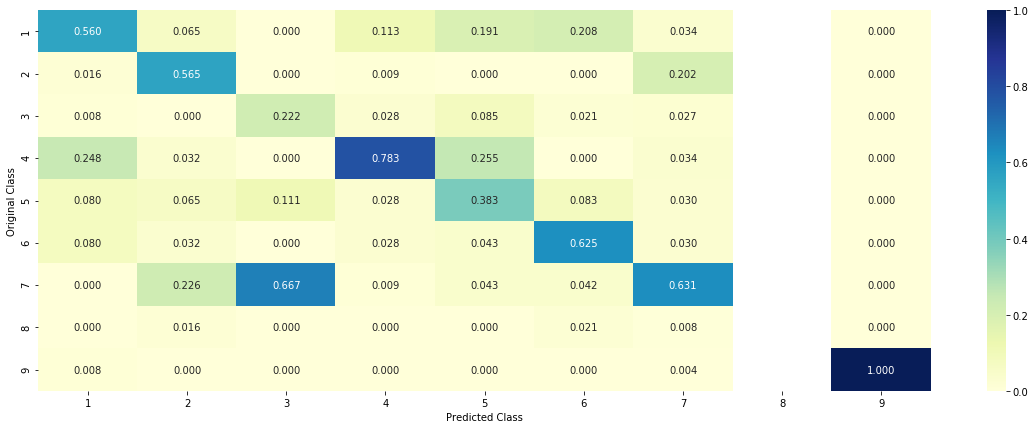

-------------------- Recall matrix (Row sum=1) --------------------


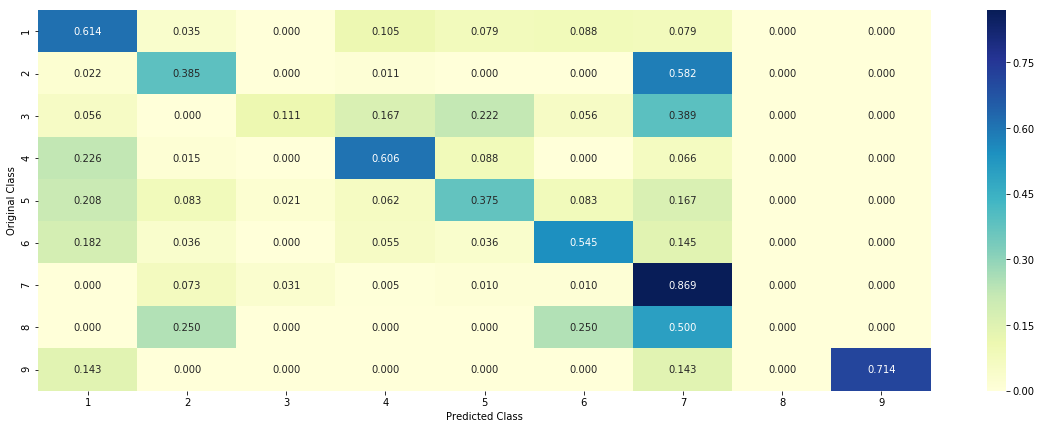

In [81]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))